<a href="https://colab.research.google.com/github/thaisflopes/mestrado_PPGA_UnB/blob/main/analise_exploratoria_dados/AED_dados_judicializacao_vfinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Código do trabalho de mestrado da aluna Thaís Ferreira Lopes Oliveira no PPGA-UnB.

### Importando bibliotecas

In [ ]:
#Importando bibliotecas
import pandas as pd
pd.set_option('display.max_colwidth', None)  # Mostra o conteúdo completo das colunas
pd.set_option('display.max_columns', None)  # Garante que todas as colunas sejam exibidas
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(color_codes=True)
from matplotlib.ticker import FuncFormatter

### Importando os dados de judicialização

In [ ]:
# Baixando a bases de dados de judicialização ajustada
dados_judicialização_final = pd.read_csv('base_judicializacao_ajustada.csv',low_memory=False)

In [ ]:
# Visualizando a quantidade de linhas e colunas
dados_judicialização_final.shape

(555625, 36)

In [ ]:
# Visualizando os tipos de dados de judicialização
dados_judicialização_final.dtypes

empresa_re                       object
numero_processo                  object
cnpj_re                          object
data_distribuicao                object
UF                               object
jurisdicao                       object
obj_principal                    object
subobj_principal                 object
valor_pedido_inicial            float64
n_autores                         int64
data_voo                         object
operacao                         object
causa_alegada                    object
situacao_processual              object
instancia                        object
resultado_decisao_sentenca       object
data_sentenca                    object
valor_dano_moral                float64
valor_dano_material             float64
valor_total_condenacao          float64
data_acordao                     object
valor_pago                      float64
num_proc_ano                      int64
numero_processo_regex            object
obj_problemas_operacionais         bool


### Preparação da base de dados para a pesquisa

**Análise das colunas:**

- **CONSIDERAR:** 'empresa_re', 'num_proc_ano', 'data_distribuicao', 'UF', 'operacao', 'jurisdicao', 'instancia', 'situacao_processual_sentenca', 'n_autores', 'data_voo', 'valor_pedido_inicial', 'valor_dano_moral', 'valor_dano_material', 'valor_total_condenacao', 'valor_pago', 'obj_problemas_operacionais', 'obj_bagagem', 'obj_contrato', 'obj_outros', 'causa_nao_informado', 'causa_forca_maior', 'causa_fortuitos', 'causa_terceiros', 'causa_cliente', 'causa_aerea', 'causa_outros', 'obj_principal', 'subobj_principal' , 'causa_alegada'

- **DESCONSIDERAR:**  'numero_processo', 'cnpj_re', 'situacao_processual', 'resultado_decisao_sentenca', 'data_sentenca', 'data_acordao', 'numero_processo_regex'

In [ ]:
# Selecionando apenas colunas que serão utilizadas
dados_judicializacao_AED = dados_judicialização_final[[
    'empresa_re', 'num_proc_ano', 'data_distribuicao', 'UF', 'operacao',
    'jurisdicao', 'instancia', 'situacao_processual_sentenca', 'n_autores', 'data_voo',
    'valor_pedido_inicial', 'valor_dano_moral', 'valor_dano_material',
    'valor_total_condenacao', 'valor_pago', 'obj_problemas_operacionais',
    'obj_bagagem', 'obj_contrato', 'obj_outros', 'causa_nao_informado',
    'causa_forca_maior', 'causa_fortuitos', 'causa_terceiros', 'causa_cliente',
    'causa_aerea', 'causa_outros', 'obj_principal', 'subobj_principal', 'causa_alegada'
]]

In [ ]:
# Ajustando valores empresa_re
dados_judicializacao_AED.loc[:, 'empresa_re'] = dados_judicializacao_AED['empresa_re'].replace('Tap', 'TAP')

In [ ]:
# Conferindo valores empresa_re
dados_judicializacao_AED.empresa_re.value_counts()

empresa_re
Azul             206654
Latam            198721
Gol              112752
TAP               18467
Copa              10831
United             8121
Não informado        79
Name: count, dtype: int64

In [ ]:
# Excluindo os dados em que a empresa_re = Não informado
dados_judicializacao_AED = dados_judicializacao_AED[~dados_judicializacao_AED.empresa_re.isin(['Não informado'])]

In [ ]:
# Conferindo valores num_proc_ano
dados_judicializacao_AED.num_proc_ano.value_counts()

num_proc_ano
2023    164501
2022    126827
2019    104637
2020     80265
2021     79316
Name: count, dtype: int64

In [ ]:
# Criando a coluna mês a partir da coluna 'data_distribuicao'

# Substituindo o ponto (.) por barra (/) e hífen (-) por NaN
dados_judicializacao_AED['data_distribuicao'] = dados_judicializacao_AED['data_distribuicao'].str.replace('.', '/', regex=False)
dados_judicializacao_AED['data_distribuicao'] = dados_judicializacao_AED['data_distribuicao'].replace('-', np.nan)

# Verificando se há valores não válidos na coluna 'data_distribuicao'
# Exemplo de filtragem: mostrar as linhas com valores inválidos (não numéricos) para depuração
dados_judicializacao_AED[pd.to_datetime(dados_judicializacao_AED['data_distribuicao'], errors='coerce').isna()]

# Garantindo que o valor de 'data_distribuicao' tenha o formato esperado antes de fazer o split
dados_judicializacao_AED['mes_distribuicao'] = dados_judicializacao_AED['data_distribuicao'].str.split('/').str[1]

# Limpando qualquer valor não numérico em 'mes'
dados_judicializacao_AED['mes_distribuicao'] = pd.to_numeric(dados_judicializacao_AED['mes_distribuicao'], errors='coerce')

# Substituindo NaN por 0
dados_judicializacao_AED['mes_distribuicao'] = dados_judicializacao_AED['mes_distribuicao'].fillna(0).astype(int)

In [ ]:
#Criando a coluna região a partir da coluna 'UF'
uf = [
    dados_judicializacao_AED['UF'].isin(['AC', 'AP', 'AM', 'PA', 'RO', 'RR', 'TO']),  # Norte
    dados_judicializacao_AED['UF'].isin(['AL', 'BA', 'CE', 'MA', 'PB', 'PE', 'PI', 'RN', 'SE']),  # Nordeste
    dados_judicializacao_AED['UF'].isin(['GO', 'MT', 'MS', 'DF']),  # Centro-Oeste
    dados_judicializacao_AED['UF'].isin(['ES', 'MG', 'RJ', 'SP']),  # Sudeste
    dados_judicializacao_AED['UF'].isin(['PR', 'RS', 'SC'])  # Sul
]

regiao = ['N', 'NE', 'CO', 'SE', 'S']

dados_judicializacao_AED['regiao'] = np.select(uf, regiao, default='Outra')

In [ ]:
# Conferindo valores regiao
dados_judicializacao_AED.regiao.value_counts()

regiao
SE    244507
NE    101586
N      74729
CO     73390
S      61334
Name: count, dtype: int64

In [ ]:
# Conferindo valores UF
dados_judicializacao_AED.UF.value_counts()

UF
SP    100690
RJ     70190
BA     60160
MG     58914
RO     51437
PR     40798
MT     28850
PE     27866
SC     20536
AM     19838
GO     18394
DF     15997
ES     14713
CE     13560
MS     10149
TO      3454
Name: count, dtype: int64

In [ ]:
# Conferindo valores operacao
dados_judicializacao_AED.operacao.value_counts()

operacao
Doméstico         365341
Internacional      97439
Não informado      79602
Outros              9358
 Internacional      3803
 Não Informado         3
Name: count, dtype: int64

In [ ]:
# Ajustando valores na coluna operacao
dados_judicializacao_AED.operacao = dados_judicializacao_AED.operacao.replace(' Internacional', 'Internacional')
dados_judicializacao_AED.operacao = dados_judicializacao_AED.operacao.replace(' Não Informado', 'Não informado')
dados_judicializacao_AED.operacao = dados_judicializacao_AED.operacao.replace('Não informado', 'Outros')

In [ ]:
# Conferindo valores jurisdicao
dados_judicializacao_AED.jurisdicao.value_counts()

jurisdicao
Juizado Especial Cível    412065
Vara Cível                136157
Outros                      7253
Não informado                 71
Name: count, dtype: int64

In [ ]:
# Ajustando valores jurisdicao
dados_judicializacao_AED.jurisdicao = dados_judicializacao_AED.jurisdicao.replace('Não informado', 'Outros')

In [ ]:
# Conferindo valores instancia
dados_judicializacao_AED.instancia.value_counts()

instancia
1ª Instância     322840
Não informado    198908
2ª Instância      33776
3ª Instância         22
Name: count, dtype: int64

In [ ]:
# Conferindo valores situacao_processual_sentenca
dados_judicializacao_AED.situacao_processual_sentenca.value_counts()

situacao_processual_sentenca
Não informado                                222072
Condenação                                   126041
Outros                                        82019
Acordo                                        81266
Decisão favorável à aérea (improcedência)     38858
Extinção sem julgamento do mérito              5290
Name: count, dtype: int64

In [ ]:
# Ajustando valores situacao_processual_sentenca
dados_judicializacao_AED.situacao_processual_sentenca = dados_judicializacao_AED.situacao_processual_sentenca.replace('Não informado', 'Outros')

In [ ]:
# Substituindo valores negativos por 0 (erros de base)
dados_judicializacao_AED.loc[dados_judicializacao_AED.valor_pedido_inicial < 0, 'valor_pedido_inicial'] = 0
dados_judicializacao_AED.loc[dados_judicializacao_AED.valor_pago < 0, 'valor_pago'] = 0

In [ ]:
# Baixando base ajustada
dados_judicializacao_AED.to_csv('dados_judicializacao_AED.csv',index=False)

### Análise Exploratória de Dados

In [ ]:
# Visualizando a quantidade de linhas e colunas
dados_judicializacao_AED.shape

(555546, 31)

In [ ]:
# Verificando os tipos de dados
print("\nTipos de Dados:")
dados_judicializacao_AED.dtypes


Tipos de Dados:


empresa_re                       object
num_proc_ano                      int64
data_distribuicao                object
UF                               object
operacao                         object
jurisdicao                       object
instancia                        object
situacao_processual_sentenca     object
n_autores                         int64
data_voo                         object
valor_pedido_inicial            float64
valor_dano_moral                float64
valor_dano_material             float64
valor_total_condenacao          float64
valor_pago                      float64
obj_problemas_operacionais         bool
obj_bagagem                        bool
obj_contrato                       bool
obj_outros                         bool
causa_nao_informado                bool
causa_forca_maior                  bool
causa_fortuitos                    bool
causa_terceiros                    bool
causa_cliente                      bool
causa_aerea                        bool


In [ ]:
# Verificando a quantidade de valores ausentes por coluna
print("\nValores ausentes por coluna:")
dados_judicializacao_AED.isnull().sum()


Valores ausentes por coluna:


empresa_re                           0
num_proc_ano                         0
data_distribuicao                  110
UF                                   0
operacao                             0
jurisdicao                           0
instancia                            0
situacao_processual_sentenca         0
n_autores                            0
data_voo                         69395
valor_pedido_inicial                 0
valor_dano_moral                     0
valor_dano_material                  0
valor_total_condenacao               0
valor_pago                           0
obj_problemas_operacionais           0
obj_bagagem                          0
obj_contrato                         0
obj_outros                           0
causa_nao_informado                  0
causa_forca_maior                    0
causa_fortuitos                      0
causa_terceiros                      0
causa_cliente                        0
causa_aerea                          0
causa_outros             

##### Descrição estatística das variáveis categóricas:

- Contagem (count): O número total de valores não nulos (não ausentes).
- Valores únicos (unique): O número de categorias ou valores distintos na coluna.
- Valor mais frequente (top): O valor mais comum ou mais frequente na coluna.
- Frequência do valor mais comum (freq): O número de vezes que o valor mais comum aparece.

In [ ]:
#### Estatísticas descritivas para variáveis categóricas
print("\nEstatísticas Descritivas - Variáveis Categóricas:")
dados_judicializacao_AED.describe(include=['object'])


Estatísticas Descritivas - Variáveis Categóricas:


empresa_re data_distribuicao      UF   operacao  \
count      555546            555436  555546     555546   
unique          6              2283      16          3   
top          Azul        01/09/2023      SP  Doméstico   
freq       206654              2801  100690     365341   

                    jurisdicao     instancia situacao_processual_sentenca  \
count                   555546        555546                       555546   
unique                       3             4                            5   
top     Juizado Especial Cível  1ª Instância                       Outros   
freq                    412065        322840                       304091   

       data_voo                  obj_principal subobj_principal causa_alegada  \
count    486151                         489101           347341        445426   
unique     4407                            792              849           180   
top           -  Atraso ou Cancelamento de Voo              ***     Culpa Tam   
freq      58618                          80710           142151        110837   

        regiao  
count   555546  
unique       5  
top         SE  
freq    244507

##### Descrição estatística das variáveis numéricas:

- count: O número total de valores não nulos (não ausentes).
- mean: A média dos valores.
- std: O desvio padrão, que indica a dispersão dos dados em relação à média.
- min: O valor mínimo na coluna.
- 25%: O primeiro quartil (Q1), que é o valor abaixo do qual 25% dos dados se encontram.
- 50% (ou median): A mediana, ou o segundo quartil, que divide os dados ao meio.
- 75%: O terceiro quartil (Q3), que é o valor abaixo do qual 75% dos dados se encontram.
- max: O valor máximo na coluna.

In [ ]:
# Descrição estatística das variáveis numéricas
print("\nEstatísticas Descritivas - Variáveis Numéricas:")
dados_judicializacao_AED.describe()


Estatísticas Descritivas - Variáveis Numéricas:


num_proc_ano      n_autores  valor_pedido_inicial  valor_dano_moral  \
count  555546.000000  555546.000000          5.555460e+05     555546.000000   
mean     2021.299327       1.077745          1.780965e+04       1856.657602   
std         1.490304       0.794367          1.188118e+05       4047.842434   
min      2019.000000       0.000000          0.000000e+00          0.000000   
25%      2020.000000       1.000000          1.000000e+04          0.000000   
50%      2022.000000       1.000000          1.500000e+04          0.000000   
75%      2023.000000       1.000000          2.072779e+04       3000.000000   
max      2023.000000      61.000000          6.179195e+07     772819.840000   

       valor_dano_material  valor_total_condenacao    valor_pago  \
count         5.555460e+05            5.555460e+05  5.555460e+05   
mean          3.818145e+02            1.506385e+03  2.127997e+03   
std           1.362744e+04            4.980281e+03  1.219707e+04   
min           0.000000e+00            0.000000e+00  0.000000e+00   
25%           0.000000e+00            0.000000e+00  0.000000e+00   
50%           0.000000e+00            0.000000e+00  0.000000e+00   
75%           0.000000e+00            1.000000e+03  3.000000e+03   
max           1.000000e+07            1.188888e+06  7.889160e+06   

       mes_distribuicao  
count     555546.000000  
mean           6.419459  
std            3.491734  
min            0.000000  
25%            3.000000  
50%            6.000000  
75%           10.000000  
max           12.000000

### Gráficos

In [ ]:
# Calcular o total de processos judiciais
total_processos = len(dados_judicializacao_AED)

##### OPERAÇÃO

In [ ]:
# Contar os processos e calcular o percentual
processos_opercao_df = dados_judicializacao_AED['operacao'].value_counts(normalize=False, sort=True).reset_index()

# Renomear as colunas
processos_opercao_df.columns = ['Operação', 'Qtd de Processos Judiciais']

# Calcular os percentuais diretamente
processos_opercao_df['Percentual (%)'] = (processos_opercao_df['Qtd de Processos Judiciais'] / processos_opercao_df['Qtd de Processos Judiciais'].sum()) * 100

# Exibir a tabela
processos_opercao_df

Operação  Qtd de Processos Judiciais  Percentual (%)
0      Doméstico                      365341       65.762511
1  Internacional                      101242       18.223873
2         Outros                       88963       16.013615

##### Nº DE AUTORES

In [ ]:
# Contar os processos e calcular o percentual
processos_autores_df = dados_judicializacao_AED['n_autores'].value_counts(normalize=False, sort=True).reset_index()

# Renomear as colunas
processos_autores_df.columns = ['Número de Autores', 'Qtd de Processos Judiciais']

# Calcular os percentuais diretamente
processos_autores_df['Percentual (%)'] = (processos_autores_df['Qtd de Processos Judiciais'] / processos_autores_df['Qtd de Processos Judiciais'].sum()) * 100

# Exibir a tabela
processos_autores_df

Número de Autores  Qtd de Processos Judiciais  Percentual (%)
0                   1                      371763       66.918491
1                   0                       86883       15.639209
2                   2                       77729       13.991461
3                   3                       10888        1.959874
4                   4                        5650        1.017017
5                   5                        1422        0.255964
6                   6                         657        0.118262
7                   7                         213        0.038341
8                   8                         139        0.025020
9                   9                          71        0.012780
10                 10                          45        0.008100
11                 11                          19        0.003420
12                 12                          14        0.002520
13                 13                          11        0.001980
14                 14                           9        0.001620
15                 15                           6        0.001080
16                 16                           4        0.000720
17                 17                           3        0.000540
18                 30                           3        0.000540
19                 28                           2        0.000360
20                 20                           2        0.000360
21                 31                           2        0.000360
22                 34                           1        0.000180
23                 56                           1        0.000180
24                 18                           1        0.000180
25                 53                           1        0.000180
26                 61                           1        0.000180
27                 55                           1        0.000180
28                 37                           1        0.000180
29                 27                           1        0.000180
30                 25                           1        0.000180
31                 22                           1        0.000180
32                 21                           1        0.000180

##### JURISDIÇÃO

In [ ]:
# Contar os processos e calcular o percentual
processos_jurisdicao_df = dados_judicializacao_AED['jurisdicao'].value_counts(normalize=False, sort=True).reset_index()

# Renomear as colunas
processos_jurisdicao_df.columns = ['Jurisdição', 'Qtd de Processos Judiciais']

# Calcular os percentuais diretamente
processos_jurisdicao_df['Percentual (%)'] = (processos_jurisdicao_df['Qtd de Processos Judiciais'] / processos_jurisdicao_df['Qtd de Processos Judiciais'].sum()) * 100

# Exibir a tabela
processos_jurisdicao_df

Jurisdição  Qtd de Processos Judiciais  Percentual (%)
0  Juizado Especial Cível                      412065       74.172976
1              Vara Cível                      136157       24.508682
2                  Outros                        7324        1.318343

##### SITUAÇÃO PROCESSUAL E SENTENÇA

In [ ]:
# Contar os processos e calcular o percentual
processos_situacao_df = dados_judicializacao_AED['situacao_processual_sentenca'].value_counts(normalize=False, sort=True).reset_index()

# Renomear as colunas
processos_situacao_df.columns = ['Situação Processual Sentença', 'Qtd de Processos Judiciais']

# Calcular os percentuais diretamente
processos_situacao_df['Percentual (%)'] = (processos_situacao_df['Qtd de Processos Judiciais'] / processos_situacao_df['Qtd de Processos Judiciais'].sum()) * 100

# Exibir a tabela
processos_situacao_df

Situação Processual Sentença  Qtd de Processos Judiciais  \
0                                     Outros                      304091   
1                                 Condenação                      126041   
2                                     Acordo                       81266   
3  Decisão favorável à aérea (improcedência)                       38858   
4          Extinção sem julgamento do mérito                        5290   

   Percentual (%)  
0       54.737321  
1       22.687770  
2       14.628132  
3        6.994560  
4        0.952216

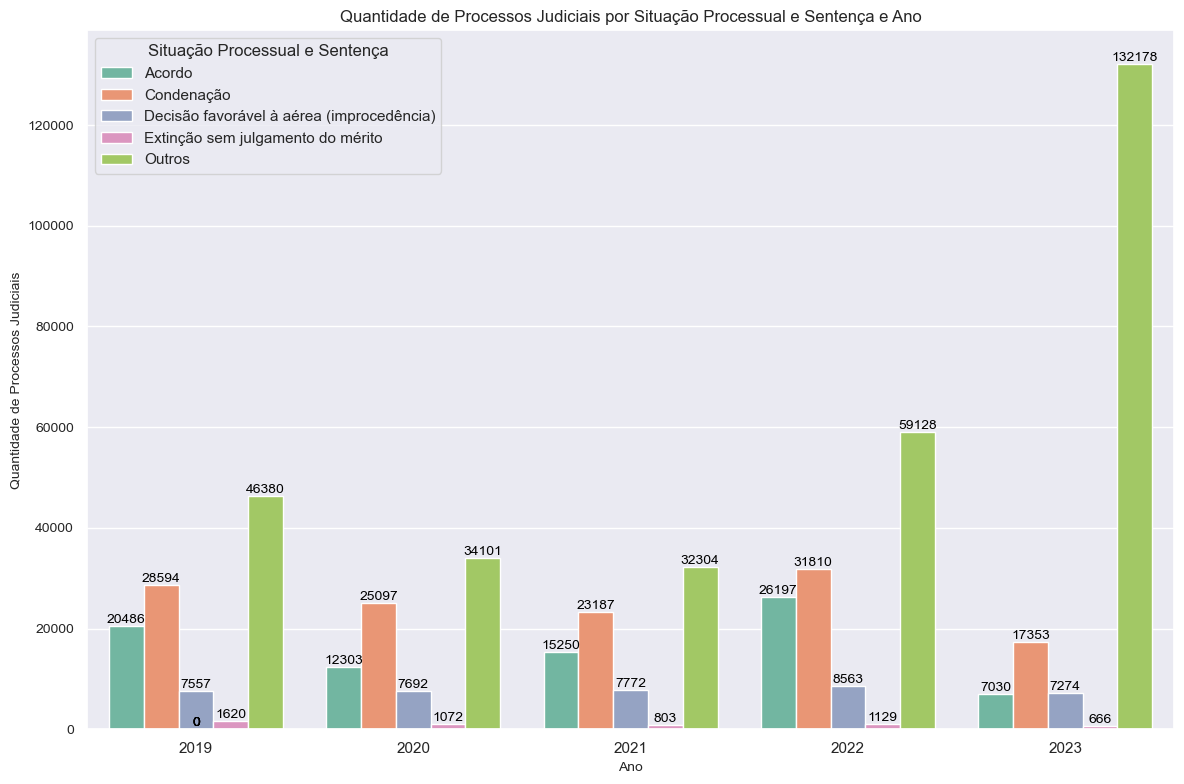

In [ ]:
# Agrupar os processos por situação processual e ano
processos_situacao_ano = dados_judicializacao_AED.groupby(['situacao_processual_sentenca', 'num_proc_ano']).size().reset_index(name='Quantidade')

# Definindo o dicionário de cores para as situações processuais
cores_situacoes = {
    'Acordo': '#66C2A5',
    'Condenação': '#FC8D62',
    'Decisão favorável à aérea (improcedência)': '#8DA0CB',
    'Extinção sem julgamento do mérito': '#E78AC3',
    'Outros': '#A6D854'
}

# Criar o gráfico de barras
plt.figure(figsize=(12, 8))
ax = sns.barplot(x='num_proc_ano', y='Quantidade', hue='situacao_processual_sentenca', data=processos_situacao_ano, palette=cores_situacoes)

# Título e rótulos dos eixos
plt.title('Quantidade de Processos Judiciais por Situação Processual e Sentença e Ano', fontsize=12)
plt.xlabel('Ano', fontsize=10)
plt.ylabel('Quantidade de Processos Judiciais', fontsize=10)
ax.legend(title='Situação Processual e Sentença')

# Adicionando os números em cima de cada barra
for p in ax.patches:
    height = p.get_height()
    x_position = p.get_x() + p.get_width() / 2
    y_position = height
    value_text = f'{height:.0f}'
    ax.annotate(value_text,
                (x_position, y_position),
                ha='center', va='bottom',
                fontsize=10, color='black')

# Ajustar o tamanho da fonte das categorias
plt.yticks(fontsize=10)

# Ajustar layout
plt.tight_layout()

# Salvar a figura em um arquivo
plt.savefig("qtd_processos_por_situacao_ano.png", format="png", dpi=300)

# Exibir o gráfico
plt.show()

In [ ]:
# Calcular o crescimento ano a ano por situação processual
processos_situacao_ano['Crescimento Anual (%)'] = processos_situacao_ano.groupby('situacao_processual_sentenca')['Quantidade'].pct_change() * 100

# Exibindo o resultado
print("\nCrescimento Percentual por Situação Processual e Sentença e Ano:")
processos_situacao_ano


Crescimento Percentual por Situação Processual e Sentença e Ano:


situacao_processual_sentenca  num_proc_ano  Quantidade  \
0                                      Acordo          2019       20486   
1                                      Acordo          2020       12303   
2                                      Acordo          2021       15250   
3                                      Acordo          2022       26197   
4                                      Acordo          2023        7030   
5                                  Condenação          2019       28594   
6                                  Condenação          2020       25097   
7                                  Condenação          2021       23187   
8                                  Condenação          2022       31810   
9                                  Condenação          2023       17353   
10  Decisão favorável à aérea (improcedência)          2019        7557   
11  Decisão favorável à aérea (improcedência)          2020        7692   
12  Decisão favorável à aérea (improcedência)          2021        7772   
13  Decisão favorável à aérea (improcedência)          2022        8563   
14  Decisão favorável à aérea (improcedência)          2023        7274   
15          Extinção sem julgamento do mérito          2019        1620   
16          Extinção sem julgamento do mérito          2020        1072   
17          Extinção sem julgamento do mérito          2021         803   
18          Extinção sem julgamento do mérito          2022        1129   
19          Extinção sem julgamento do mérito          2023         666   
20                                     Outros          2019       46380   
21                                     Outros          2020       34101   
22                                     Outros          2021       32304   
23                                     Outros          2022       59128   
24                                     Outros          2023      132178   

    Crescimento Anual (%)  
0                     NaN  
1              -39.944352  
2               23.953507  
3               71.783607  
4              -73.164866  
5                     NaN  
6              -12.229838  
7               -7.610471  
8               37.188942  
9              -45.447972  
10                    NaN  
11               1.786423  
12               1.040042  
13              10.177560  
14             -15.053136  
15                    NaN  
16             -33.827160  
17             -25.093284  
18              40.597758  
19             -41.009743  
20                    NaN  
21             -26.474774  
22              -5.269640  
23              83.036157  
24             123.545528

##### INSTÂNCIA

In [ ]:
# Contar os processos e calcular o percentual
processos_instancia_df = dados_judicializacao_AED['instancia'].value_counts(normalize=False, sort=True).reset_index()

# Renomear as colunas
processos_instancia_df.columns = ['Instancia', 'Qtd de Processos Judiciais']

# Calcular os percentuais diretamente
processos_instancia_df['Percentual (%)'] = (processos_instancia_df['Qtd de Processos Judiciais'] / processos_instancia_df['Qtd de Processos Judiciais'].sum()) * 100

# Exibir a tabela
processos_instancia_df

Instancia  Qtd de Processos Judiciais  Percentual (%)
0   1ª Instância                      322840       58.112200
1  Não informado                      198908       35.804056
2   2ª Instância                       33776        6.079785
3   3ª Instância                          22        0.003960

##### ANO E MÊS DE DISTRIBUIÇÃO

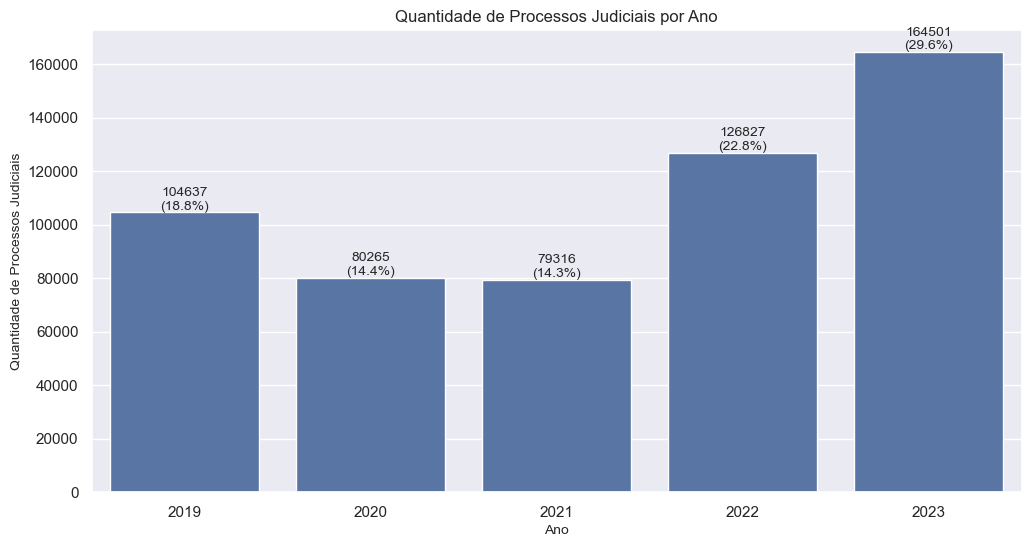

In [ ]:
# Contar os processos de cada ano
processos_ano = dados_judicializacao_AED.groupby(['num_proc_ano']).size().reset_index(name='Quantidade')

# Criar o gráfico de barras
plt.figure(figsize=(12, 6))
ax = sns.countplot(data=dados_judicializacao_AED, x='num_proc_ano')

# Título e rótulos dos eixos
plt.title('Quantidade de Processos Judiciais por Ano', fontsize=12)
plt.xlabel('Ano', fontsize=10)
plt.ylabel('Quantidade de Processos Judiciais', fontsize=10)

# Adicionando os números e percentuais em cima de cada barra
for p in ax.patches:
    height = p.get_height()
    percentage = (height / total_processos) * 100
    ax.annotate(f'{int(height)}\n({percentage:.1f}%)',
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=10)

# Salvar a figura em um arquivo
plt.savefig("qtd_processos_por_ano_com_percentual.png", format="png", dpi=300)

# Exibir o gráfico
plt.show()

In [ ]:
# Calcular o crescimento ano a ano
processos_ano['Crescimento Anual (%)'] = processos_ano['Quantidade'].pct_change() * 100

# Exibindo o resultado
print("\nCrescimento Percentual Ano a Ano:")
processos_ano


Crescimento Percentual Ano a Ano:


num_proc_ano  Quantidade  Crescimento Anual (%)
0          2019      104637                    NaN
1          2020       80265             -23.291952
2          2021       79316              -1.182334
3          2022      126827              59.900903
4          2023      164501              29.705031

In [ ]:
# Contar os processos por ano e mês
processos_ano_mes = dados_judicializacao_AED.groupby(['mes_distribuicao', 'num_proc_ano']).size().unstack(fill_value=0)

# Calcular o total de processos por mês
processos_ano_mes['Total'] = processos_ano_mes.sum(axis=1)

# Calcular o percentual do total para cada mês
processos_ano_mes['Percentual do Total'] = (processos_ano_mes['Total'] / total_processos) * 100

# Exibir a tabela
processos_ano_mes

num_proc_ano       2019   2020  2021   2022   2023  Total  Percentual do Total
mes_distribuicao                                                              
0                    47     10    21    788    134   1000             0.180003
1                  6993  10534  5618  10102  11336  44583             8.025078
2                  8140  10925  6612  12562  12440  50679             9.122377
3                  8646  11174  8006  12645  16330  56801            10.224356
4                  8545   5672  6296   9888  12025  42426             7.636811
5                  9015   5481  6004  10762  13906  45168             8.130380
6                  6884   5323  6017   9976  12884  41084             7.395247
7                  8789   5752  6346  10006  13353  44246             7.964417
8                  9439   4549  6307  11342  12416  44053             7.929676
9                  9155   4665  6064  10169  15565  45618             8.211381
10                10265   5210  6477  10308  14999  47259             8.506766
11                 9832   5481  7819   9886  15915  48933             8.808091
12                 8887   5489  7729   8393  13198  43696             7.865415

In [ ]:
# Criar copia da base para analise de intervalo de tempo entre data de voo e data de distribuição
dados_judicializacao_analise = dados_judicializacao_AED

# Converter as colunas para formato datetime
dados_judicializacao_analise['data_voo_dt'] = pd.to_datetime(dados_judicializacao_analise['data_voo'], errors='coerce', dayfirst=True)
dados_judicializacao_analise['data_distribuicao_dt'] = pd.to_datetime(dados_judicializacao_analise['data_distribuicao'], errors='coerce', dayfirst=True)

# Calcular o intervalo de tempo em meses
dados_judicializacao_analise['intervalo_meses'] = (
    (dados_judicializacao_analise['data_distribuicao_dt'] - dados_judicializacao_analise['data_voo_dt']).dt.days / 30
).round()

# Encontrar o mínimo e o máximo
min_meses = dados_judicializacao_analise['intervalo_meses'].min()
max_meses = dados_judicializacao_analise['intervalo_meses'].max()
print(f"Mínimo: {min_meses} meses, Máximo: {max_meses} meses")

# Verificando a quantidade de valores ausentes por coluna
print("\nValores ausentes por coluna:")
dados_judicializacao_analise[['data_voo', 'data_distribuicao', 'data_voo_dt', 'data_distribuicao_dt', 'intervalo_meses']].isnull().sum()

Mínimo: -2188.0 meses, Máximo: 1485.0 meses

Valores ausentes por coluna:


data_voo                 69395
data_distribuicao          110
data_voo_dt             141469
data_distribuicao_dt      1016
intervalo_meses         141481
dtype: int64

In [ ]:
# Excluir linhas com valores nulos na coluna 'intervalo_meses'
dados_judicializacao_analise = dados_judicializacao_analise.dropna(subset=['intervalo_meses'])

# Visualizando a quantidade de linhas e colunas
dados_judicializacao_analise.shape

(414065, 34)

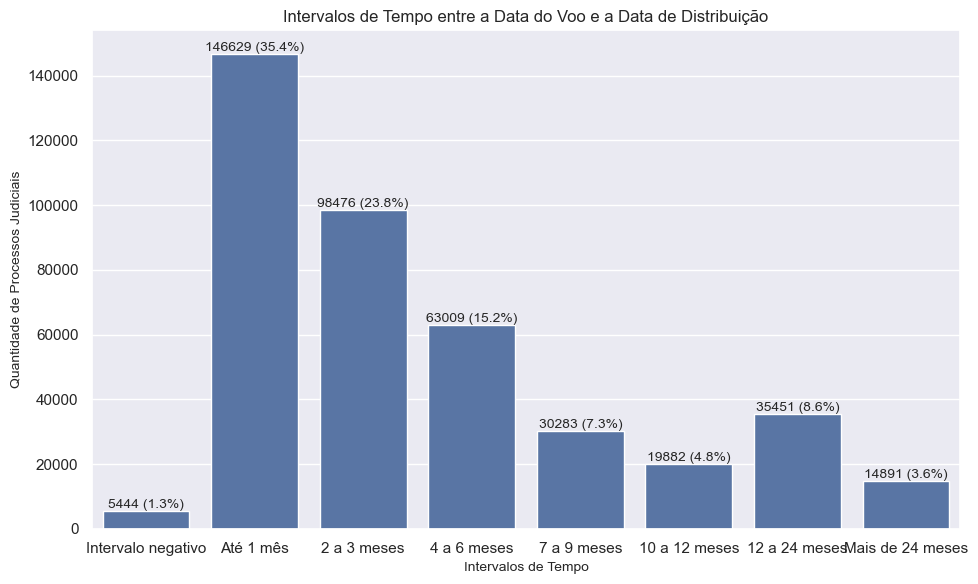

In [ ]:
# Criar intervalos personalizados, incluindo o intervalo negativo
bins = [-float('inf'), -1, 1, 3, 6, 9, 12, 24, float('inf')]  # Definindo os limites dos intervalos
labels = ['Intervalo negativo', 'Até 1 mês', '2 a 3 meses', '4 a 6 meses', '7 a 9 meses', '10 a 12 meses', '12 a 24 meses', 'Mais de 24 meses']

# Garantir que estamos modificando o DataFrame original utilizando .loc[]
dados_judicializacao_analise.loc[:, 'categoria_intervalo'] = pd.cut(
    dados_judicializacao_analise['intervalo_meses'], bins=bins, labels=labels, right=True, include_lowest=True
)

# Converter a coluna para tipo categórico também usando .loc[]
dados_judicializacao_analise.loc[:, 'categoria_intervalo'] = dados_judicializacao_analise['categoria_intervalo'].astype('category')

# Contar a quantidade de casos por intervalo
contagem_intervalos = dados_judicializacao_analise['categoria_intervalo'].value_counts().sort_index()

# Calcular o total de processos
total_processos_analise = contagem_intervalos.sum()

# Criar o gráfico
plt.figure(figsize=(10, 6))
sns.barplot(x=contagem_intervalos.index, y=contagem_intervalos.values)

# Adicionar título e rótulos
plt.title('Intervalos de Tempo entre a Data do Voo e a Data de Distribuição', fontsize=12)
plt.xlabel('Intervalos de Tempo', fontsize=10)
plt.ylabel('Quantidade de Processos Judiciais', fontsize=10)

# Adicionar rótulos com valores absolutos e percentuais
for i, value in enumerate(contagem_intervalos.values):
    percentage = (value / total_processos_analise) * 100
    plt.text(
        i,
        value + 0.5,
        f'{value} ({percentage:.1f}%)',
        ha='center', va='bottom', fontsize=10
    )

# Ajustar layout
plt.tight_layout()

# Salvar a figura em um arquivo
plt.savefig("intervalos_datavoo_datadistribuicao_com_percentual.png", format="png", dpi=300)

# Exibir o gráfico
plt.show()

##### REGIÃO E UF

In [ ]:
# Contar os processos de cada região
processos_regiao = dados_judicializacao_AED['regiao'].value_counts()

# Definindo o dicionário de cores para as regiões
cores_regioes = {
    'N': '#66C2A5',
    'NE': '#FC8D62',
    'CO': '#8DA0CB',
    'SE': '#E78AC3',
    'S': '#A6D854'
}

# Criar o gráfico de barras horizontais, ordenando pelas regiões com mais processos
plt.figure(figsize=(12, 6))
ax = sns.countplot(data=dados_judicializacao_AED, y='regiao', hue='regiao',
                   order=processos_regiao.index, palette=cores_regioes)

# Título e rótulos dos eixos
plt.title('Quantidade de Processos Judiciais por Região', fontsize=12)
plt.ylabel('Região', fontsize=10)
plt.xlabel('Quantidade de Processos Judiciais', fontsize=10)

# Adicionando os números e percentuais ao lado de cada barra
for p in ax.patches:
    width = p.get_width()
    percentage = (width / total_processos) * 100
    ax.annotate(f'{int(width)}\n({percentage:.1f}%)',
                (width, p.get_y() + p.get_height() / 2.),
                ha='left', va='center', fontsize=10)

# Ajustando o layout para o gráfico
plt.tight_layout()

# Salvar a figura em um arquivo
plt.savefig("qtd_processos_por_regiao_com_percentual.png", format="png", dpi=300)

# Exibir o gráfico
plt.show()

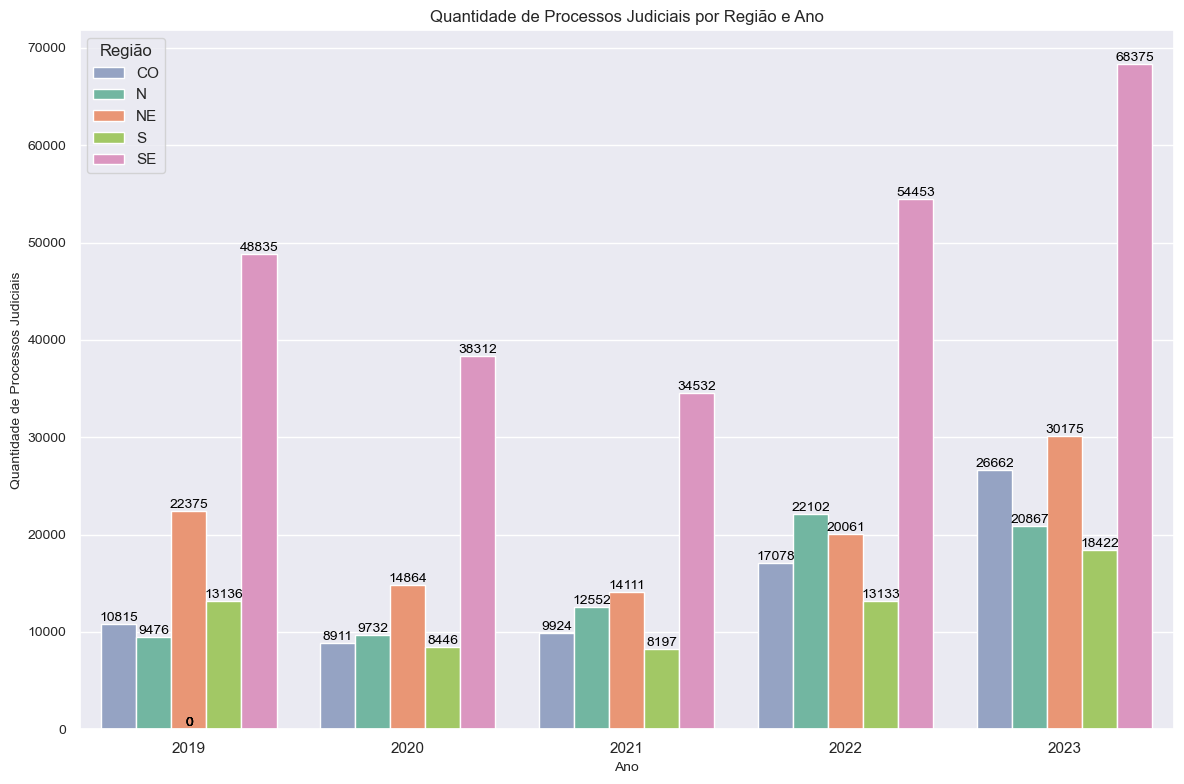

In [ ]:
# Agrupar as processos por região e ano
processos_regiao_ano = dados_judicializacao_AED.groupby(['regiao', 'num_proc_ano']).size().reset_index(name='Quantidade')

# Definindo o dicionário de cores para as regiões
cores_regioes = {
    'N': '#66C2A5',
    'NE': '#FC8D62',
    'CO': '#8DA0CB',
    'SE': '#E78AC3',
    'S': '#A6D854'
}

# Criar o gráfico de barras
plt.figure(figsize=(12, 8))
ax = sns.barplot(x='num_proc_ano', y='Quantidade', hue='regiao', data=processos_regiao_ano, palette=cores_regioes)

# Título e rótulos dos eixos
plt.title('Quantidade de Processos Judiciais por Região e Ano', fontsize=12)
plt.xlabel('Ano', fontsize=10)
plt.ylabel('Quantidade de Processos Judiciais', fontsize=10)
ax.legend(title='Região')

# Adicionando os números e percentuais em cima de cada barra
for p in ax.patches:
    # Pega a altura da barra para posicionar o rótulo
    height = p.get_height()
    x_position = p.get_x() + p.get_width() / 2  # Centraliza o texto na largura da barra
    y_position = height  # Posiciona o texto no topo da barra

    # Formatação do texto: quantidade de processos
    value_text = f'{height:.0f}'

    # Adiciona o rótulo com o número de processos na parte superior da barra
    ax.annotate(value_text,
                (x_position, y_position),
                ha='center', va='bottom',  # Alinha o texto no topo da barra
                fontsize=10, color='black')

# Ajustar o tamanho da fonte das categorias
plt.yticks(fontsize=10)

# Ajustar layout
plt.tight_layout()

# Salvar a figura em um arquivo
plt.savefig("qtd_processos_por_regiao_ano.png", format="png", dpi=300)

# Exibir o gráfico
plt.show()

In [ ]:
# Calcular o crescimento ano a ano por região
processos_regiao_ano['Crescimento Anual (%)'] = processos_regiao_ano.groupby('regiao')['Quantidade'].pct_change() * 100

# Exibindo o resultado
print("\nCrescimento Percentual por Região e Ano:")
processos_regiao_ano


Crescimento Percentual por Região e Ano:


regiao  num_proc_ano  Quantidade  Crescimento Anual (%)
0      CO          2019       10815                    NaN
1      CO          2020        8911             -17.605178
2      CO          2021        9924              11.367972
3      CO          2022       17078              72.087868
4      CO          2023       26662              56.118983
5       N          2019        9476                    NaN
6       N          2020        9732               2.701562
7       N          2021       12552              28.976572
8       N          2022       22102              76.083493
9       N          2023       20867              -5.587730
10     NE          2019       22375                    NaN
11     NE          2020       14864             -33.568715
12     NE          2021       14111              -5.065931
13     NE          2022       20061              42.165686
14     NE          2023       30175              50.416230
15      S          2019       13136                    NaN
16      S          2020        8446             -35.703410
17      S          2021        8197              -2.948141
18      S          2022       13133              60.217153
19      S          2023       18422              40.272596
20     SE          2019       48835                    NaN
21     SE          2020       38312             -21.548070
22     SE          2021       34532              -9.866360
23     SE          2022       54453              57.688521
24     SE          2023       68375              25.567003

In [ ]:
# Contar as processos por Ano e UF
processos_ano_uf = dados_judicializacao_AED.groupby(['UF', 'num_proc_ano']).size().unstack(fill_value=0)

# Calcular o total de processos por UF
processos_ano_uf['Total'] = processos_ano_uf.sum(axis=1)

# Calcular o percentual do total para cada UF
processos_ano_uf['Percentual do Total'] = (processos_ano_uf['Total'] / total_processos) * 100

# Ordenar as UF pelo total de processos (do maior para o menor)
processos_ano_uf = processos_ano_uf.sort_values(by='Total', ascending=False)

# Exibir a tabela
processos_ano_uf

num_proc_ano   2019   2020   2021   2022   2023   Total  Percentual do Total
UF                                                                          
SP            19305  16832  13734  22596  28223  100690            18.124512
RJ            14677  10416  10862  15519  18716   70190            12.634417
BA            12443   8486   8762  12208  18261   60160            10.828986
MG            11756   9006   7775  12972  17405   58914            10.604702
RO             6830   6765   8735  16633  12474   51437             9.258819
PR             9268   5708   5693   8862  11267   40798             7.343766
MT             2840   2882   3081   7063  12984   28850             5.193089
PE             7390   4429   3646   5197   7204   27866             5.015966
SC             3868   2738   2504   4271   7155   20536             3.696544
AM             2007   2492   3278   4755   7306   19838             3.570901
GO             2727   2384   2845   4220   6218   18394             3.310977
DF             3505   2401   2559   3438   4094   15997             2.879510
ES             3097   2058   2161   3366   4031   14713             2.648386
CE             2542   1949   1703   2656   4710   13560             2.440842
MS             1743   1244   1439   2357   3366   10149             1.826851
TO              639    475    539    714   1087    3454             0.621731

##### EMPRESA AEREA

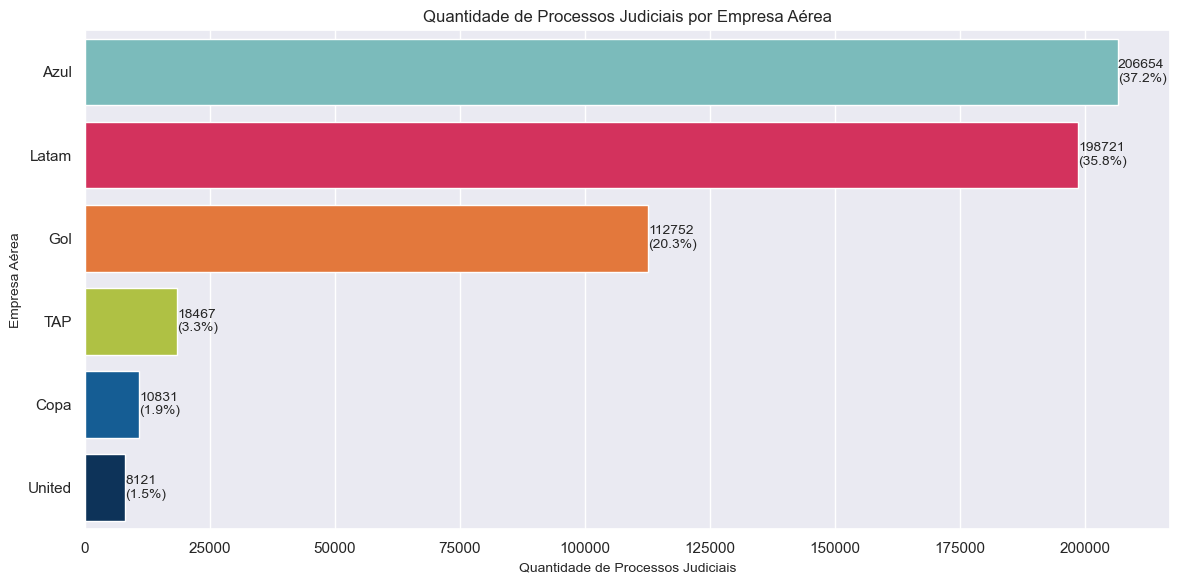

In [ ]:
# Contar as processos de cada empresa
processos_empresa = dados_judicializacao_AED['empresa_re'].value_counts()

# Definindo o dicionário de cores para as empresas
cores_empresas = {
    'Azul': '#70C6C6',
    'Copa': '#0060A9',
    'Gol': '#FF7020',
    'Latam': '#EE1750',
    'TAP': '#BED62F',
    'United': '#003366'
}

# Criar o gráfico de barras horizontais
plt.figure(figsize=(12, 6))
ax = sns.countplot(data=dados_judicializacao_AED, y='empresa_re', hue='empresa_re',
                   order=processos_empresa.index, palette=cores_empresas)

# Título e rótulos dos eixos
plt.title('Quantidade de Processos Judiciais por Empresa Aérea', fontsize=12)
plt.ylabel('Empresa Aérea', fontsize=10)
plt.xlabel('Quantidade de Processos Judiciais', fontsize=10)

# Adicionando os números e percentuais ao lado de cada barra
for p in ax.patches:
    width = p.get_width()  # Agora é a largura, pois estamos usando barras horizontais
    percentage = (width / total_processos) * 100
    ax.annotate(f'{int(width)}\n({percentage:.1f}%)',
                (width, p.get_y() + p.get_height() / 2.),
                ha='left', va='center', fontsize=10)

# Ajustar o layout para o gráfico
plt.tight_layout()

# Salvar a figura em um arquivo
plt.savefig("qtd_processos_por_empresa_com_percentual.png", format="png", dpi=300)

# Exibir o gráfico
plt.show()

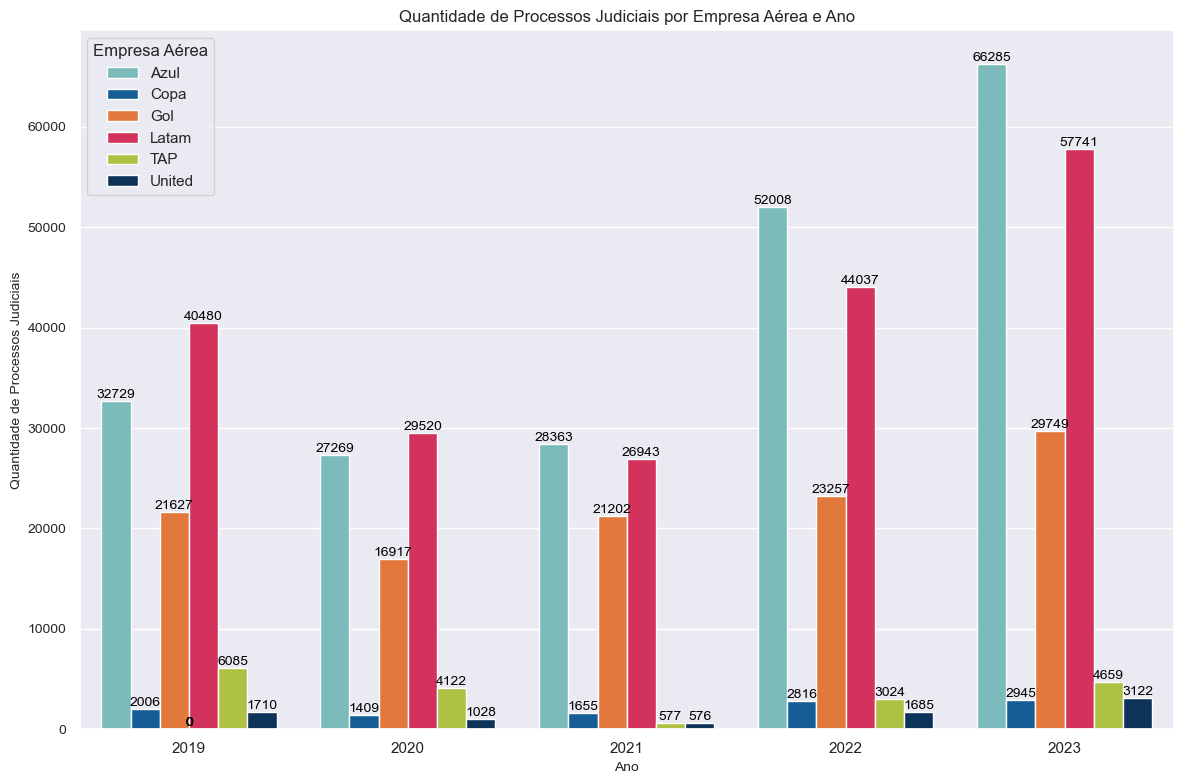

In [ ]:
# Agrupar os processos por empresa e Ano de Abertura
processos_empresa_ano = dados_judicializacao_AED.groupby(['empresa_re', 'num_proc_ano']).size().reset_index(name='Quantidade')

# Definindo o dicionário de cores para as empresas
cores_empresas = {
    'Azul': '#70C6C6',
    'Copa': '#0060A9',
    'Gol': '#FF7020',
    'Latam': '#EE1750',
    'TAP': '#BED62F',
    'United': '#003366'
}

# Criar o gráfico de barras
plt.figure(figsize=(12, 8))
ax = sns.barplot(x='num_proc_ano', y='Quantidade', hue='empresa_re', data=processos_empresa_ano, palette=cores_empresas)

# Título e rótulos dos eixos
plt.title('Quantidade de Processos Judiciais por Empresa Aérea e Ano', fontsize=12)
plt.xlabel('Ano', fontsize=10)
plt.ylabel('Quantidade de Processos Judiciais', fontsize=10)
ax.legend(title='Empresa Aérea')

# Adicionar a quantidade de processos na parte superior das barras
for p in ax.patches:
    # Pega a altura da barra para posicionar o rótulo
    height = p.get_height()
    x_position = p.get_x() + p.get_width() / 2  # Centraliza o texto na largura da barra
    y_position = height  # Posiciona o texto no topo da barra

    # Formatação do texto: quantidade de processos
    value_text = f'{height:.0f}'

    # Adiciona o rótulo com o número de processos na parte superior da barra
    ax.annotate(value_text,
                (x_position, y_position),
                ha='center', va='bottom',  # Alinha o texto no topo da barra
                fontsize=10, color='black')

# Ajustar o tamanho da fonte das categorias
plt.yticks(fontsize=10)

# Ajustar layout
plt.tight_layout()

# Salvar a figura em um arquivo
plt.savefig("qtd_processos_por_empresa_ano.png", format="png", dpi=300)

# Exibir o gráfico
plt.show()

In [ ]:
# Calcular o crescimento ano a ano por empresa
processos_empresa_ano['Crescimento Anual (%)'] = processos_empresa_ano.groupby('empresa_re')['Quantidade'].pct_change() * 100

# Exibindo o resultado
print("\nCrescimento Percentual por Empresa Aérea e Ano:")
processos_empresa_ano


Crescimento Percentual por Empresa Aérea e Ano:


empresa_re  num_proc_ano  Quantidade  Crescimento Anual (%)
0        Azul          2019       32729                    NaN
1        Azul          2020       27269             -16.682453
2        Azul          2021       28363               4.011882
3        Azul          2022       52008              83.365652
4        Azul          2023       66285              27.451546
5        Copa          2019        2006                    NaN
6        Copa          2020        1409             -29.760718
7        Copa          2021        1655              17.459191
8        Copa          2022        2816              70.151057
9        Copa          2023        2945               4.580966
10        Gol          2019       21627                    NaN
11        Gol          2020       16917             -21.778333
12        Gol          2021       21202              25.329550
13        Gol          2022       23257               9.692482
14        Gol          2023       29749              27.914176
15      Latam          2019       40480                    NaN
16      Latam          2020       29520             -27.075099
17      Latam          2021       26943              -8.729675
18      Latam          2022       44037              63.445051
19      Latam          2023       57741              31.119286
20        TAP          2019        6085                    NaN
21        TAP          2020        4122             -32.259655
22        TAP          2021         577             -86.001941
23        TAP          2022        3024             424.090121
24        TAP          2023        4659              54.067460
25     United          2019        1710                    NaN
26     United          2020        1028             -39.883041
27     United          2021         576             -43.968872
28     United          2022        1685             192.534722
29     United          2023        3122              85.281899

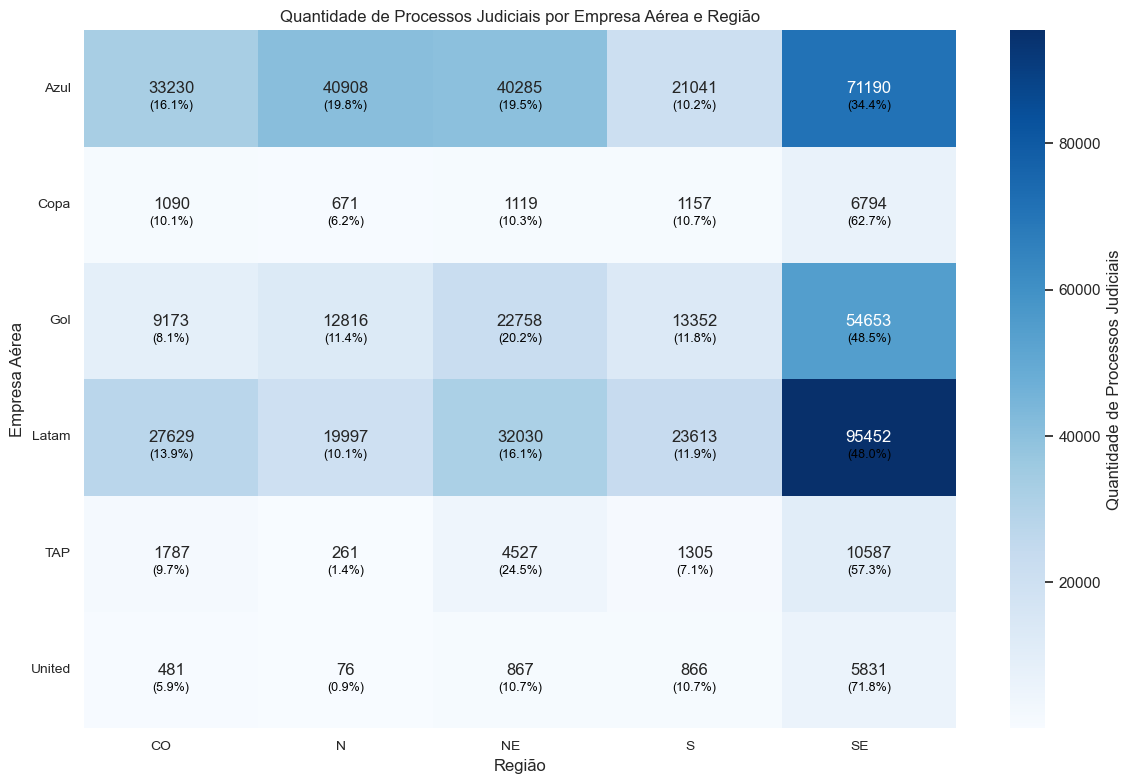

In [ ]:
# Agrupar os processos por Empresa e Região
processos_empresa_regiao = dados_judicializacao_AED.groupby(['empresa_re', 'regiao']).size().reset_index(name='Quantidade')

# Criar uma tabela de contingência (pivot) com a quantidade de processos
tabela_contingencia = processos_empresa_regiao.pivot(index='empresa_re', columns='regiao', values='Quantidade')

# Calcular o total de processos para cada empresa
totais_empresa = tabela_contingencia.sum(axis=1)

# Calcular o percentual de cada valor em relação ao total de processos da empresa
tabela_percentual = tabela_contingencia.div(totais_empresa, axis=0) * 100

# Criar o gráfico de mapa de calor
plt.figure(figsize=(12, 8))
ax = sns.heatmap(tabela_contingencia, annot=True, fmt="d", cmap="Blues", cbar_kws={'label': 'Quantidade de Processos Judiciais'})

# Adicionar os percentuais abaixo dos valores absolutos
for (i, j), val in np.ndenumerate(tabela_contingencia.values):
    percentual = tabela_percentual.iloc[i, j]
    # Adicionando o percentual abaixo do valor absoluto (com ajuste de posição vertical)
    ax.text(j + 0.5, i + 0.65, f'({percentual:.1f}%)', ha='center', va='center', fontsize=9, color = 'black')

# Título do gráfico
plt.title('Quantidade de Processos Judiciais por Empresa Aérea e Região', fontsize=12)

# Ajustar o tamanho da fonte dos rótulos
plt.xlabel('Região', fontsize=12)
plt.ylabel('Empresa Aérea', fontsize=12)
plt.xticks(rotation=0, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)

# Ajustar layout
plt.tight_layout()

# Salvar a figura em um arquivo
plt.savefig("qtd_processos_por_empresa_regiao.png", format="png", dpi=300)

# Exibir o gráfico
plt.show()

##### CATEGORIAS DE MOTIVOS/OBJETOS

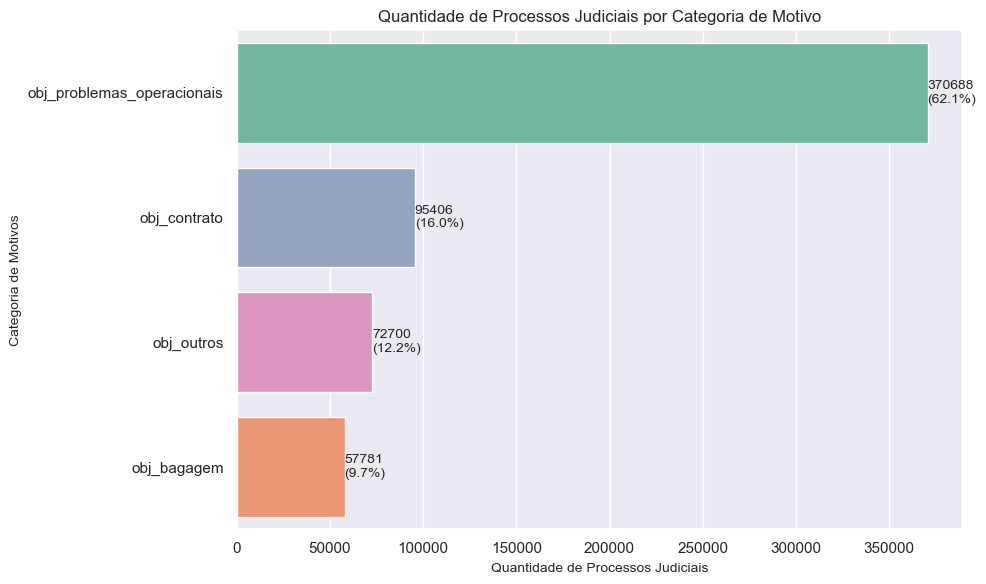

In [ ]:
# Definindo o dicionário de cores para os motivos
cores_motivos = {
    'obj_problemas_operacionais': '#66C2A5',
    'obj_bagagem': '#FC8D62',
    'obj_contrato': '#8DA0CB',
    'obj_outros': '#E78AC3',
}

# Contabilizar as ocorrências de 1 em cada uma das colunas de motivos
categorias_motivos = ['obj_problemas_operacionais', 'obj_bagagem', 'obj_contrato', 'obj_outros']

# Criar um novo DataFrame com as somas das ocorrências
processos_motivos = dados_judicializacao_AED[categorias_motivos].sum().reset_index()
processos_motivos.columns = ['Categoria', 'Quantidade de Processos Judiciais']

# Ordenar o DataFrame pelas maiores quantidades
processos_motivos = processos_motivos.sort_values(by='Quantidade de Processos Judiciais', ascending=False)

# Criar o gráfico de barras horizontais
plt.figure(figsize=(10, 6))
sns.barplot(data=processos_motivos, x='Quantidade de Processos Judiciais', y='Categoria', hue='Categoria', palette=cores_motivos)

# Título e rótulos
plt.title('Quantidade de Processos Judiciais por Categoria de Motivo', fontsize=12)
plt.xlabel('Quantidade de Processos Judiciais', fontsize=10)
plt.ylabel('Categoria de Motivos', fontsize=10)

# Adicionando os números e percentuais ao lado de cada barra
total_processos_motivos = processos_motivos['Quantidade de Processos Judiciais'].sum()
for p in plt.gca().patches:
    width = p.get_width()  # Agora é a largura, pois estamos usando barras horizontais
    percentage = (width / total_processos_motivos) * 100
    plt.gca().annotate(f'{int(width)}\n({percentage:.1f}%)',
                       (width, p.get_y() + p.get_height() / 2.),
                       ha='left', va='center', fontsize=10)

# Ajustar o layout para o gráfico
plt.tight_layout()

# Salvar a figura em um arquivo
plt.savefig("qtd_processos_por_motivos_com_percentual.png", format="png", dpi=300)

# Exibir o gráfico
plt.show()

In [ ]:
# Agrupar os dados por ano e somar as ocorrências de cada categoria de motivo
processos_ano_motivo = dados_judicializacao_AED.groupby(['num_proc_ano'])[categorias_motivos].sum()

# Calcular o total de processos judiciais por ano
processos_ano_motivo['Total'] = processos_ano_motivo.sum(axis=1)

# Calcular o total de processos por categoria
totais_por_categoria_ano = processos_ano_motivo[categorias_motivos].sum()

# Adicionar os totais por categoria como uma linha
processos_ano_motivo.loc['Total'] = totais_por_categoria_ano

# Adicionar o total geral (total de processos)
total_geral = processos_ano_motivo['Total'].sum()

# Transpor o DataFrame
processos_ano_motivo_transposta = processos_ano_motivo.transpose()

# Exibir a tabela
processos_ano_motivo_transposta

num_proc_ano                    2019     2020     2021      2022      2023  \
obj_problemas_operacionais   84318.0  61279.0  58981.0   94700.0   71410.0   
obj_bagagem                  12008.0   8188.0   6741.0   16700.0   14144.0   
obj_contrato                 12344.0  16064.0  24206.0   27342.0   15450.0   
obj_outros                    1029.0    879.0    823.0    1360.0   68609.0   
Total                       109699.0  86410.0  90751.0  140102.0  169613.0   

num_proc_ano                   Total  
obj_problemas_operacionais  370688.0  
obj_bagagem                  57781.0  
obj_contrato                 95406.0  
obj_outros                   72700.0  
Total                            NaN

In [ ]:
# Agrupar os dados por regiao e somar as ocorrências de cada categoria de motivo
processos_regiao_motivo = dados_judicializacao_AED.groupby(['regiao'])[categorias_motivos].sum()

# Calcular o total de processos judiciais por regiao
processos_regiao_motivo['Total'] = processos_regiao_motivo.sum(axis=1)

# Calcular o total de processos por categoria
totais_por_categoria_regiao = processos_regiao_motivo[categorias_motivos].sum()

# Adicionar os totais por categoria como uma linha
processos_regiao_motivo.loc['Total'] = totais_por_categoria_regiao

# Adicionar o total geral (total de processos)
total_geral_regiao = processos_regiao_motivo['Total'].sum()

# Transpor o DataFrame
processos_regiao_motivo_transposta = processos_regiao_motivo.transpose()

# Exibir a tabela
processos_regiao_motivo_transposta

regiao                           CO        N        NE        S        SE  \
obj_problemas_operacionais  44464.0  53550.0   67828.0  42021.0  162825.0   
obj_bagagem                  6984.0   5408.0   10178.0   6913.0   28298.0   
obj_contrato                11748.0   9355.0   18616.0   9999.0   45688.0   
obj_outros                  14638.0  12257.0   13443.0   7330.0   25032.0   
Total                       77834.0  80570.0  110065.0  66263.0  261843.0   

regiao                         Total  
obj_problemas_operacionais  370688.0  
obj_bagagem                  57781.0  
obj_contrato                 95406.0  
obj_outros                   72700.0  
Total                            NaN

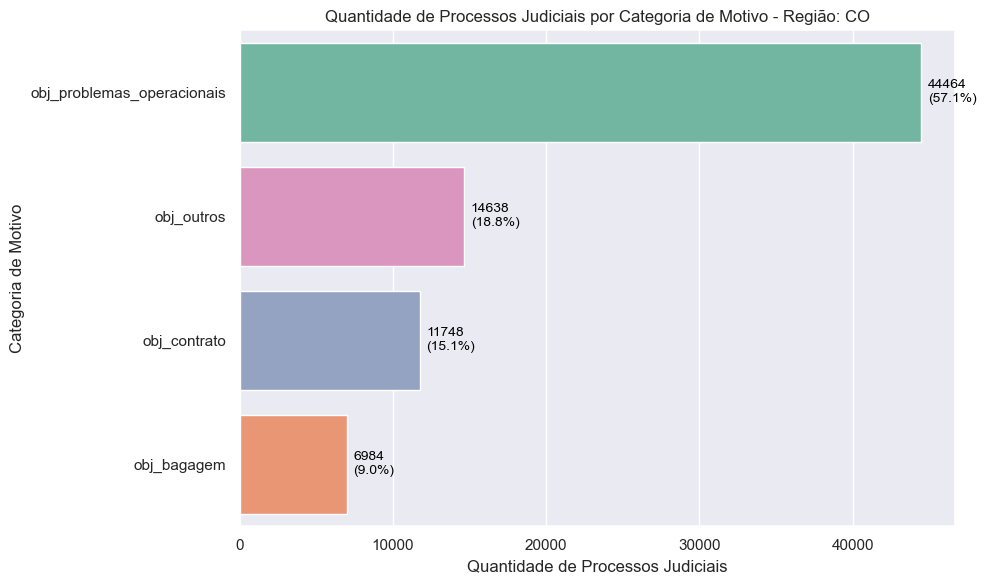

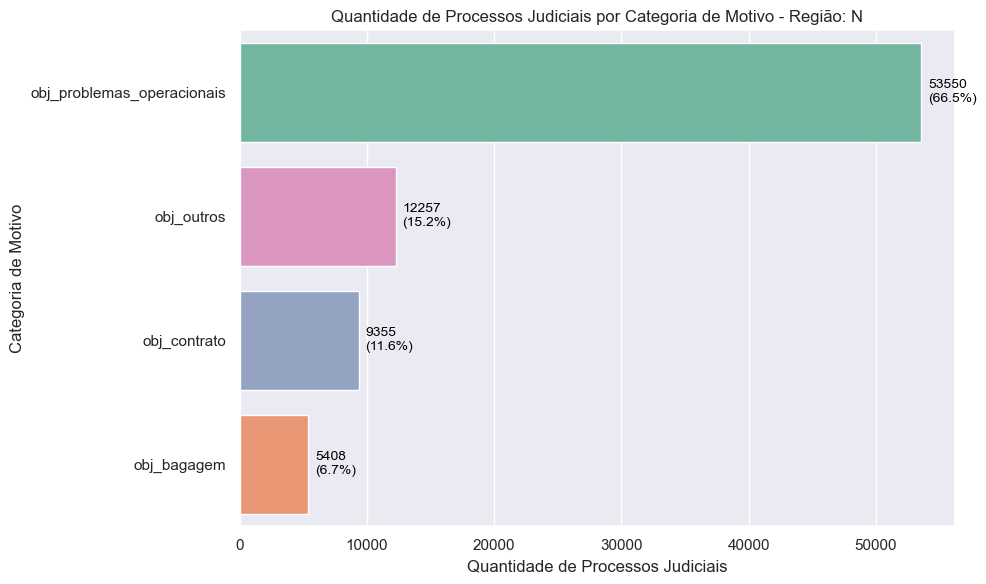

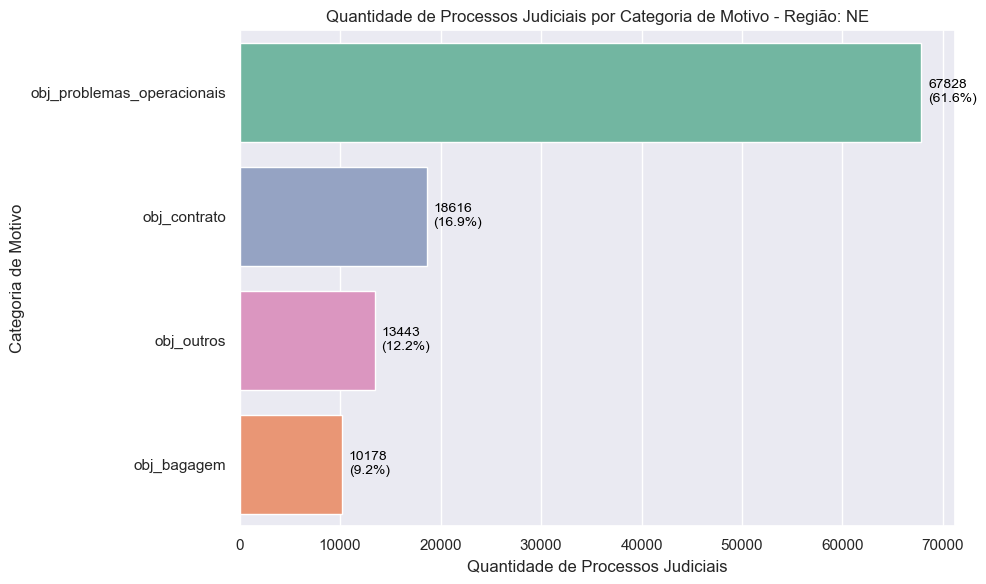

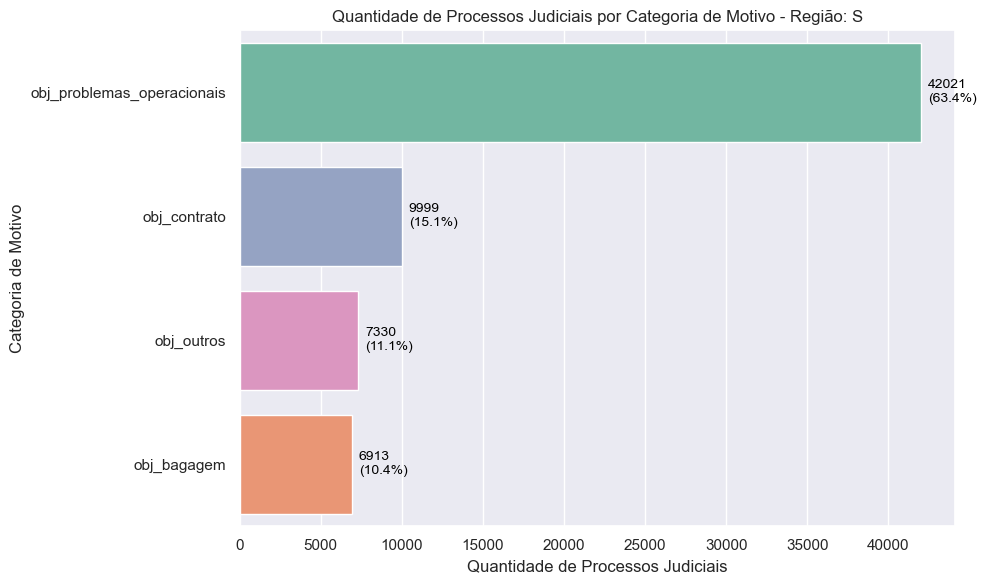

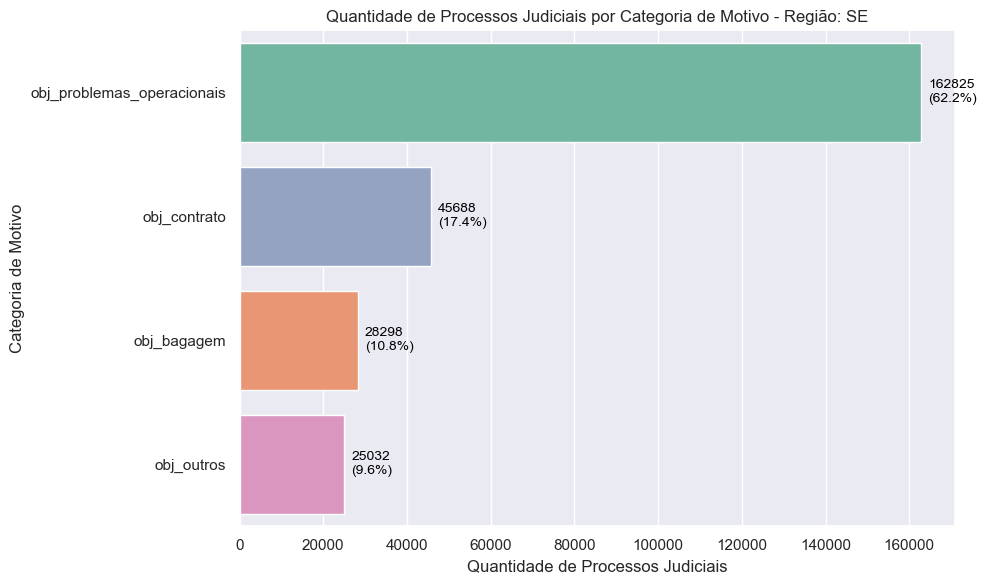

In [ ]:
# Definindo o dicionário de cores para os motivos
cores_motivos = {
    'obj_problemas_operacionais': '#66C2A5',
    'obj_bagagem': '#FC8D62',
    'obj_contrato': '#8DA0CB',
    'obj_outros': '#E78AC3',
}

# Agrupar os dados por Região e somar as ocorrências de cada categoria de motivo
processos_regiao_motivo = dados_judicializacao_AED.groupby(['regiao'])[categorias_motivos].sum()

# Calcular o total de processos por Região
processos_regiao_motivo['Total'] = processos_regiao_motivo.sum(axis=1)

# Criar um gráfico para cada região
for regiao in processos_regiao_motivo.index:
    # Selecionar os dados da região
    dados_regiao = processos_regiao_motivo.loc[regiao, categorias_motivos]

    # Ordenar os dados da região do maior para o menor
    dados_regiao = dados_regiao.sort_values(ascending=False)  # Ordem decrescente para barras do maior para o menor

    # Plotar o gráfico de barras horizontais
    plt.figure(figsize=(10, 6))
    sns.barplot(x=dados_regiao.values, y=dados_regiao.index, palette=cores_motivos, orient='h', hue=dados_regiao.index)

    # Título e rótulos
    plt.title(f'Quantidade de Processos Judiciais por Categoria de Motivo - Região: {regiao}', fontsize=12)
    plt.xlabel('Quantidade de Processos Judiciais', fontsize=12)
    plt.ylabel('Categoria de Motivo', fontsize=12)

    # Calcular o total de processos judiciais para a região
    total_processos_regiao = dados_regiao.sum()

    # Adicionar os valores e percentuais nas barras
    for p in plt.gca().patches:
        width = p.get_width()  # Agora é a largura, pois estamos usando barras horizontais
        percentage = (width / total_processos_regiao) * 100
        plt.gca().annotate(f'{int(width)}\n({percentage:.1f}%)',
                           (width, p.get_y() + p.get_height() / 2.),
                           ha='left', va='center', fontsize=10, color='black', xytext=(5, 0), textcoords='offset points')

    # Ajustar o layout para o gráfico
    plt.tight_layout()

    # Salvar o gráfico em formato PNG
    plt.savefig(f"processos_motivo_regiao_{regiao}.png", format="png", dpi=300)

    # Exibir o gráfico
    plt.show()

In [ ]:
# Agrupar os dados por empresa e somar as ocorrências de cada categoria de motivo
processos_empresa_motivo = dados_judicializacao_AED.groupby(['empresa_re'])[categorias_motivos].sum()

# Calcular o total de processos judiciais por empresa
processos_empresa_motivo['Total'] = processos_empresa_motivo.sum(axis=1)

# Calcular o total de processos por categoria
totais_por_categoria_empresa = processos_empresa_motivo[categorias_motivos].sum()

# Adicionar os totais por categoria como uma linha
processos_empresa_motivo.loc['Total'] = totais_por_categoria_empresa

# Adicionar o total geral (total de processos)
total_geral_empresa = processos_empresa_motivo['Total'].sum()

# Transpor o DataFrame
processos_empresa_motivo_transposta = processos_empresa_motivo.transpose()

# Exibir a tabela
processos_empresa_motivo_transposta

empresa_re                      Azul     Copa       Gol     Latam      TAP  \
obj_problemas_operacionais  118561.0   6228.0   91239.0  139828.0   7942.0   
obj_bagagem                  12098.0   2091.0    8466.0   26917.0   7060.0   
obj_contrato                 23089.0   2977.0   31322.0   33752.0   2909.0   
obj_outros                   66485.0    300.0    2602.0    1624.0   1629.0   
Total                       220233.0  11596.0  133629.0  202121.0  19540.0   

empresa_re                  United     Total  
obj_problemas_operacionais  6890.0  370688.0  
obj_bagagem                 1149.0   57781.0  
obj_contrato                1357.0   95406.0  
obj_outros                    60.0   72700.0  
Total                       9456.0       NaN

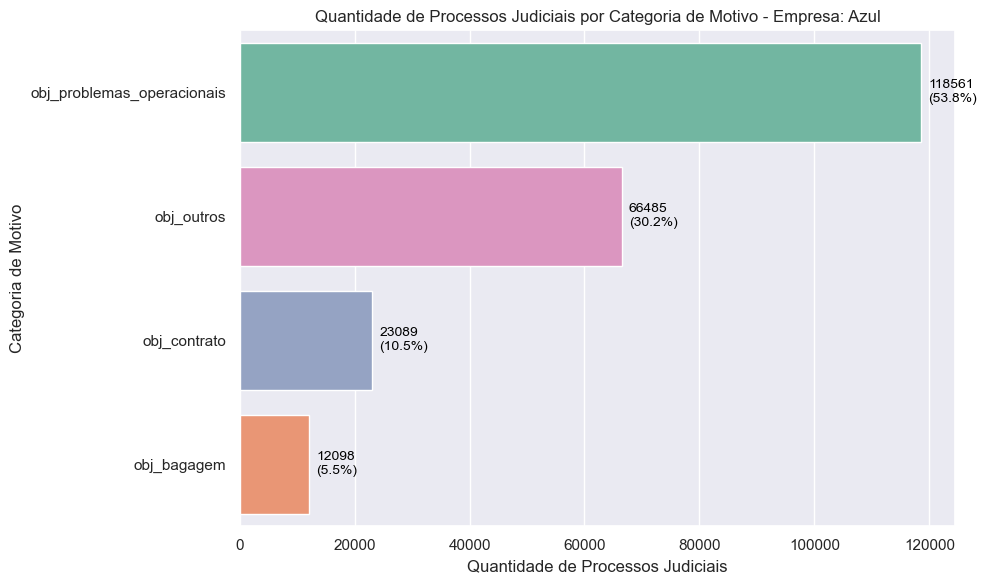

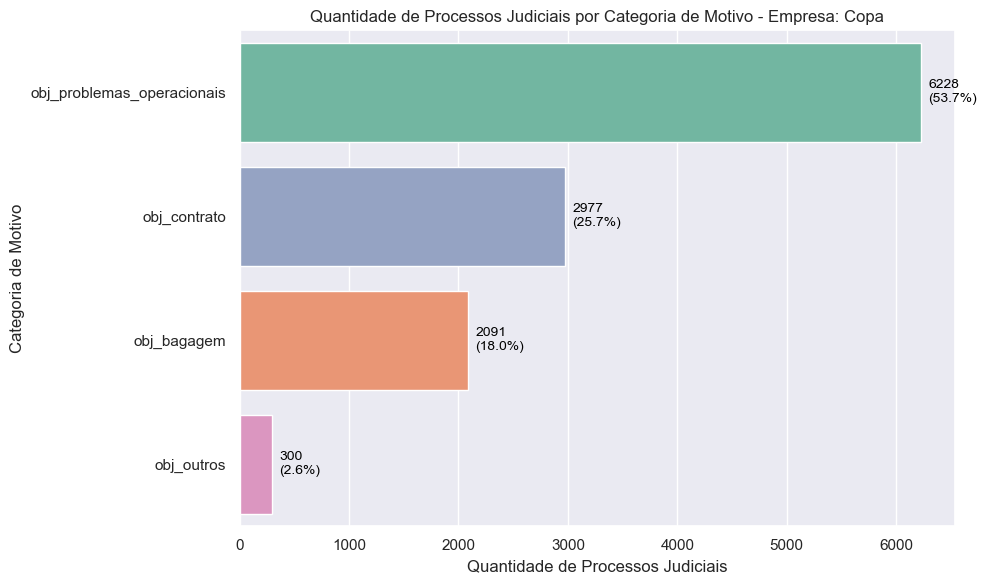

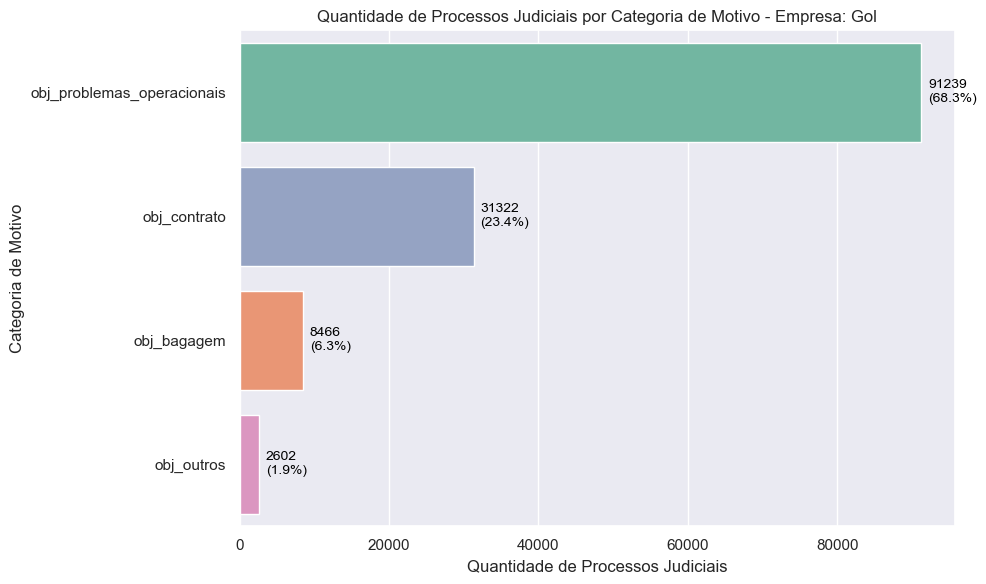

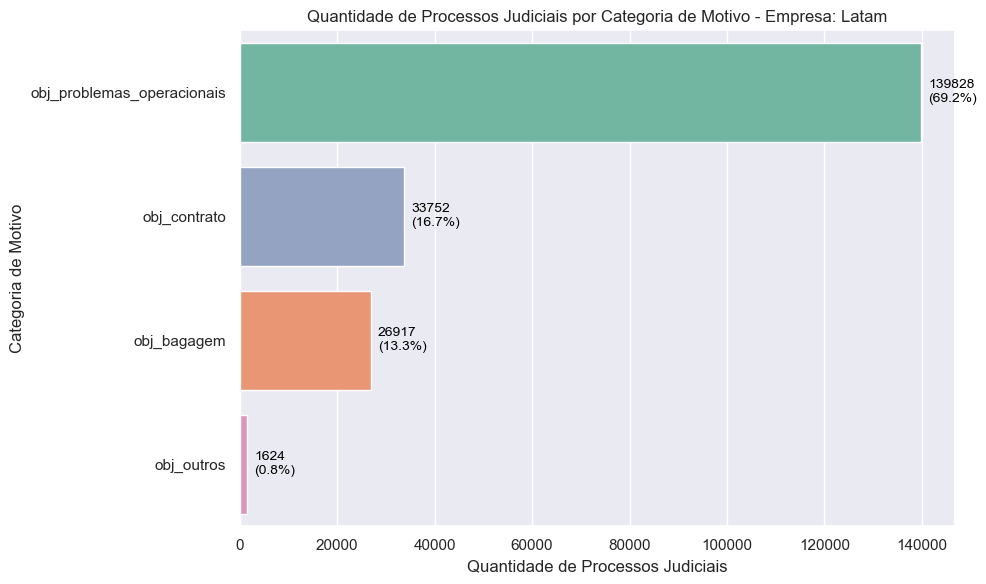

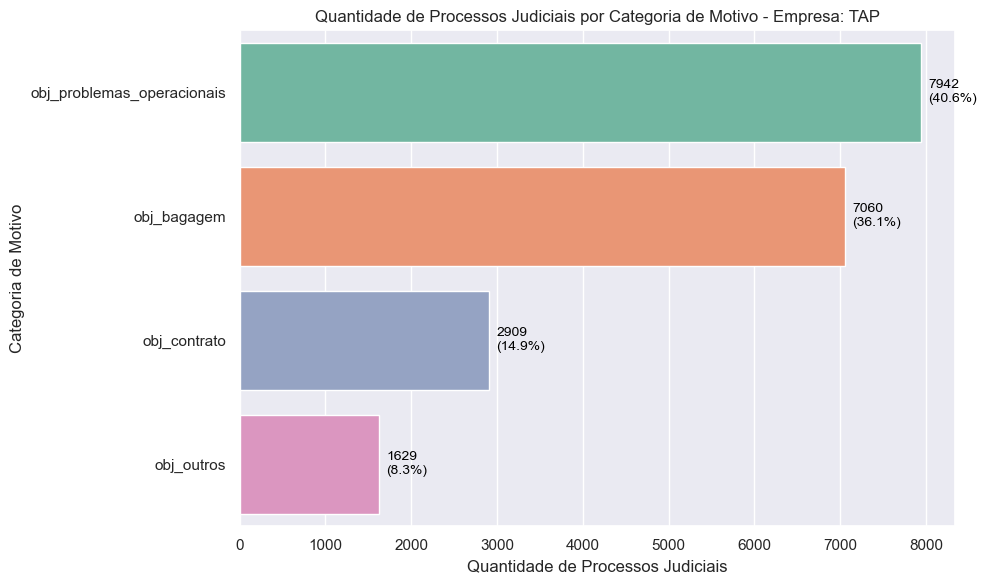

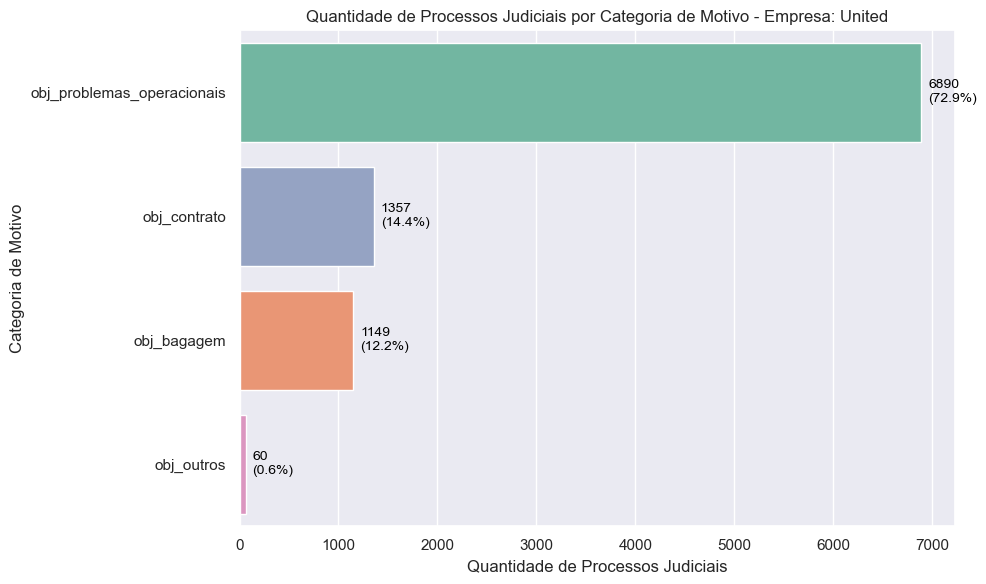

In [ ]:
# Definindo o dicionário de cores para os motivos
cores_motivos = {
    'obj_problemas_operacionais': '#66C2A5',
    'obj_bagagem': '#FC8D62',
    'obj_contrato': '#8DA0CB',
    'obj_outros': '#E78AC3',
}

# Agrupar os dados por empresa e somar as ocorrências de cada categoria de motivo
processos_empresa_motivo = dados_judicializacao_AED.groupby(['empresa_re'])[categorias_motivos].sum()

# Calcular o total de processos judiciais por empresa
processos_empresa_motivo['Total'] = processos_empresa_motivo.sum(axis=1)

# Criar um gráfico para cada empresa
for empresa in processos_empresa_motivo.index:
    # Selecionar os dados da empresa
    dados_empresa = processos_empresa_motivo.loc[empresa, categorias_motivos]

    # Ordenar os dados da empresa do maior para o menor
    dados_empresa = dados_empresa.sort_values(ascending=False)  # Ordem decrescente para barras do maior para o menor

    # Plotar o gráfico de barras horizontais
    plt.figure(figsize=(10, 6))
    sns.barplot(x=dados_empresa.values, y=dados_empresa.index, palette=cores_motivos, orient='h', hue=dados_empresa.index)

    # Título e rótulos
    plt.title(f'Quantidade de Processos Judiciais por Categoria de Motivo - Empresa: {empresa}', fontsize=12)
    plt.xlabel('Quantidade de Processos Judiciais', fontsize=12)
    plt.ylabel('Categoria de Motivo', fontsize=12)

    # Calcular o total de processos judiciais para a empresa
    total_processos_empresa = dados_empresa.sum()

    # Adicionar os valores e percentuais nas barras
    for p in plt.gca().patches:
        width = p.get_width()  # Agora é a largura, pois estamos usando barras horizontais
        percentage = (width / total_processos_empresa) * 100
        plt.gca().annotate(f'{int(width)}\n({percentage:.1f}%)',
                           (width, p.get_y() + p.get_height() / 2.),
                           ha='left', va='center', fontsize=10, color='black', xytext=(5, 0), textcoords='offset points')

    # Ajustar o layout para o gráfico
    plt.tight_layout()

    # Salvar o gráfico em formato PNG
    plt.savefig(f"processos_motivo_empresa_{empresa}.png", format="png", dpi=300)

    # Exibir o gráfico
    plt.show()

In [ ]:
# Agrupar os dados por 'obj_principal', 'suboj_principal' e 'num_proc_ano' para contar o número de processos por motivo e ano
processos_obj_ano = dados_judicializacao_AED.groupby(['obj_principal', 'subobj_principal', 'num_proc_ano']).size().reset_index(name='Quantidade de Processos')

# Calcular os percentuais por ano para 'obj_principal' e 'suboj_principal'
total_processos_por_ano = processos_obj_ano.groupby('num_proc_ano')['Quantidade de Processos'].transform('sum')
processos_obj_ano['Percentual (%)'] = (processos_obj_ano['Quantidade de Processos'] / total_processos_por_ano) * 100

# Incluir as colunas 'obj_problemas_operacionais', 'obj_bagagem', 'obj_contrato', 'obj_outros' para ver a classificação
processos_obj_ano = processos_obj_ano.merge(dados_judicializacao_AED[['obj_principal', 'subobj_principal', 'num_proc_ano', 'obj_problemas_operacionais',
                                                                      'obj_bagagem', 'obj_contrato', 'obj_outros']].drop_duplicates(),
                                            on=['obj_principal', 'subobj_principal', 'num_proc_ano'], how='left')

# Selecionar o top 5 por ano
top_5_por_ano = []
for ano in processos_obj_ano['num_proc_ano'].unique():
    top_5_ano = processos_obj_ano[processos_obj_ano['num_proc_ano'] == ano] \
                    .sort_values(by='Quantidade de Processos', ascending=False) \
                    .head(5)  # Seleciona os 5 maiores com base no número de processos
    top_5_por_ano.append(top_5_ano)

# Concatenar todos os top 5 por ano em um único DataFrame
top_5_df_motivos = pd.concat(top_5_por_ano)

# Reorganizar as colunas no formato desejado
top_5_df_motivos = top_5_df_motivos[['obj_principal', 'subobj_principal', 'num_proc_ano', 'Quantidade de Processos', 'Percentual (%)',
                      'obj_problemas_operacionais', 'obj_bagagem', 'obj_contrato', 'obj_outros']]

# Salvar o DataFrame top_5_df_motivos em um arquivo Excel
top_5_df_motivos.to_excel('top_5_processos_por_ano_com_classificacao_motivos.xlsx', index=False)

# Exibir o resultado final
top_5_df_motivos

obj_principal         subobj_principal  num_proc_ano  \
1116  CANCELAMENTO DE VOO                      ***          2022   
553        Atraso de vÃ´o                      ***          2022   
2950            REEMBOLSO            Não Realizado          2022   
38     ALTERAÃÃO DE VOO                      ***          2022   
800               BAGAGEM      Extravio Temporário          2022   
1114  CANCELAMENTO DE VOO                      ***          2020   
551        Atraso de vÃ´o                      ***          2020   
798               BAGAGEM      Extravio Temporário          2020   
36     ALTERAÃÃO DE VOO                      ***          2020   
2948            REEMBOLSO            Não Realizado          2020   
1115  CANCELAMENTO DE VOO                      ***          2021   
1026         CANCELAMENTO                 COVID-19          2021   
37     ALTERAÃÃO DE VOO                      ***          2021   
2949            REEMBOLSO            Não Realizado          2021   
552        Atraso de vÃ´o                      ***          2021   
1113  CANCELAMENTO DE VOO                      ***          2019   
550        Atraso de vÃ´o                      ***          2019   
35     ALTERAÃÃO DE VOO                      ***          2019   
107                ATRASO  ATR. V. - TRÁFEGO AÉREO          2019   
797               BAGAGEM      Extravio Temporário          2019   
1117  CANCELAMENTO DE VOO                      ***          2023   
557         Atraso de vôo                      ***          2023   
801               BAGAGEM      Extravio Temporário          2023   
111                ATRASO  ATR. V. - TRÁFEGO AÉREO          2023   
41       ALTERAÇÃO DE VOO                      ***          2023   

      Quantidade de Processos  Percentual (%)  obj_problemas_operacionais  \
1116                    13323       16.968948                        True   
553                      6060        7.718369                        True   
2950                     4986        6.350460                       False   
38                       4164        5.303513                        True   
800                      3837        4.887027                       False   
1114                    10653       19.166967                        True   
551                      5431        9.771501                        True   
798                      2221        3.996042                       False   
36                       1943        3.495862                        True   
2948                     1862        3.350126                       False   
1115                     8708       16.325459                        True   
1026                     5537       10.380577                        True   
37                       3840        7.199100                        True   
2949                     2984        5.594301                       False   
552                      2679        5.022497                        True   
1113                    13418       18.448044                        True   
550                      9185       12.628207                        True   
35                       4076        5.603982                        True   
107                      3864        5.312509                        True   
797                      3692        5.076030                       False   
1117                    17294       19.874734                        True   
557                     13862       15.930587                        True   
801                      5423        6.232259                       False   
111                      5278        6.065621                        True   
41                       5263        6.048382                        True   

      obj_bagagem  obj_contrato  obj_outros  
1116        False         False       False  
553         False         False       False  
2950        False          True       False  
38          False         False       False  
800       

##### CATEGORIAS DE CAUSAS

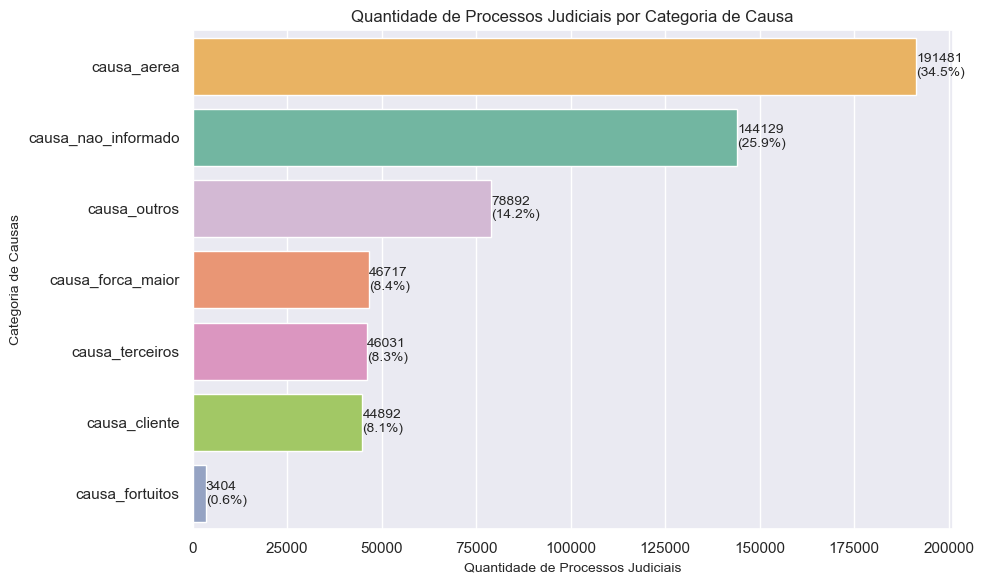

In [ ]:
# Definindo o dicionário de cores para as causas
cores_causas = {
    'causa_nao_informado': '#66C2A5',
    'causa_forca_maior': '#FC8D62',
    'causa_fortuitos': '#8DA0CB',
    'causa_terceiros': '#E78AC3',
    'causa_cliente': '#A6D854',
    'causa_aerea': '#FFB74D',
    'causa_outros': '#D7B5D8'
}

# Contabilizar as ocorrências de 1 em cada uma das colunas de causas
categorias_causas = ['causa_nao_informado', 'causa_forca_maior', 'causa_fortuitos', 'causa_terceiros', 'causa_cliente', 'causa_aerea', 'causa_outros']

# Criar um novo DataFrame com as somas das ocorrências
processos_causas = dados_judicializacao_AED[categorias_causas].sum().reset_index()
processos_causas.columns = ['Categoria', 'Quantidade de Processos Judiciais']

# Ordenar o DataFrame pelas maiores quantidades
processos_causas = processos_causas.sort_values(by='Quantidade de Processos Judiciais', ascending=False)

# Criar o gráfico de barras horizontais
plt.figure(figsize=(10, 6))
sns.barplot(data=processos_causas, x='Quantidade de Processos Judiciais', y='Categoria', hue='Categoria', palette=cores_causas)

# Título e rótulos
plt.title('Quantidade de Processos Judiciais por Categoria de Causa', fontsize=12)
plt.xlabel('Quantidade de Processos Judiciais', fontsize=10)
plt.ylabel('Categoria de Causas', fontsize=10)

# Adicionando os números e percentuais ao lado de cada barra
total_processos_causas = processos_causas['Quantidade de Processos Judiciais'].sum()
for p in plt.gca().patches:
    width = p.get_width()  # Agora é a largura, pois estamos usando barras horizontais
    percentage = (width / total_processos_causas) * 100
    plt.gca().annotate(f'{int(width)}\n({percentage:.1f}%)',
                       (width, p.get_y() + p.get_height() / 2.),
                       ha='left', va='center', fontsize=10)

# Ajustar o layout para o gráfico
plt.tight_layout()

# Salvar a figura em um arquivo
plt.savefig("qtd_processos_por_causas_com_percentual.png", format="png", dpi=300)

# Exibir o gráfico
plt.show()

In [ ]:
# Agrupar os dados por ano e somar as ocorrências de cada categoria de motivo
processos_ano_causa = dados_judicializacao_AED.groupby(['num_proc_ano'])[categorias_causas].sum()

# Calcular o total de processos judiciais por ano
processos_ano_causa['Total'] = processos_ano_causa.sum(axis=1)

# Calcular o total de processos por categoria
totais_por_categoria_ano = processos_ano_causa[categorias_causas].sum()

# Adicionar os totais por categoria como uma linha
processos_ano_causa.loc['Total'] = totais_por_categoria_ano

# Adicionar o total geral (total de processos)
total_geral = processos_ano_causa['Total'].sum()

# Transpor o DataFrame
processos_ano_causa_transposta = processos_ano_causa.transpose()

# Exibir a tabela
processos_ano_causa_transposta

num_proc_ano             2019     2020     2021      2022      2023     Total
causa_nao_informado   33989.0  29600.0  29216.0   46224.0    5100.0  144129.0
causa_forca_maior      5424.0   8958.0  11870.0   11029.0    9436.0   46717.0
causa_fortuitos        1352.0    657.0    252.0    1143.0       0.0    3404.0
causa_terceiros       10628.0   5917.0   4539.0    7935.0   17012.0   46031.0
causa_cliente          9005.0   7124.0   7741.0   10953.0   10069.0   44892.0
causa_aerea           41819.0  26508.0  24833.0   47254.0   51067.0  191481.0
causa_outros           2420.0   1501.0    865.0    2289.0   71817.0   78892.0
Total                104637.0  80265.0  79316.0  126827.0  164501.0       NaN

In [ ]:
# Agrupar os dados por região e somar as ocorrências de cada categoria de causa
processos_regiao_causa = dados_judicializacao_AED.groupby(['regiao'])[categorias_causas].sum()

# Calcular o total de processos judiciais por região
processos_regiao_causa['Total'] = processos_regiao_causa.sum(axis=1)

# Calcular o total de processos por categoria
totais_por_categoria_regiao = processos_regiao_causa[categorias_causas].sum()

# Adicionar os totais por categoria como uma linha
processos_regiao_causa.loc['Total'] = totais_por_categoria_regiao

# Adicionar o total geral (total de processos)
total_geral = processos_regiao_causa['Total'].sum()

# Transpor o DataFrame
processos_regiao_causa_transposta = processos_regiao_causa.transpose()

# Exibir a tabela
processos_regiao_causa_transposta

regiao                    CO        N        NE        S        SE     Total
causa_nao_informado  11339.0  28940.0   29198.0  15662.0   58990.0  144129.0
causa_forca_maior     4605.0   5512.0    8020.0   6271.0   22309.0   46717.0
causa_fortuitos        151.0     32.0     305.0    340.0    2576.0    3404.0
causa_terceiros       4613.0   4945.0    9911.0   6474.0   20088.0   46031.0
causa_cliente         6472.0   3591.0    7129.0   4693.0   23007.0   44892.0
causa_aerea          30676.0  19053.0   32332.0  20013.0   89407.0  191481.0
causa_outros         15534.0  12656.0   14691.0   7881.0   28130.0   78892.0
Total                73390.0  74729.0  101586.0  61334.0  244507.0       NaN

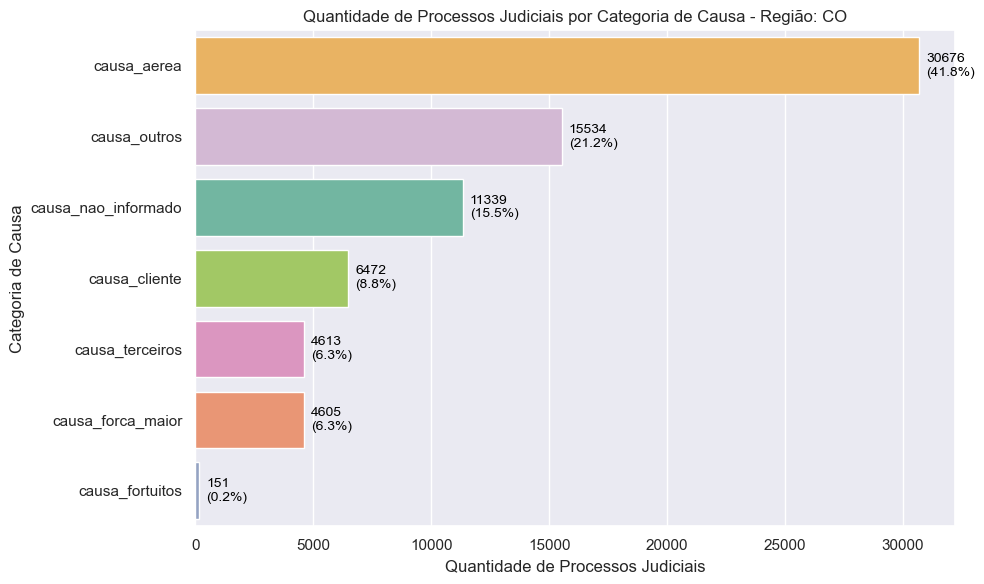

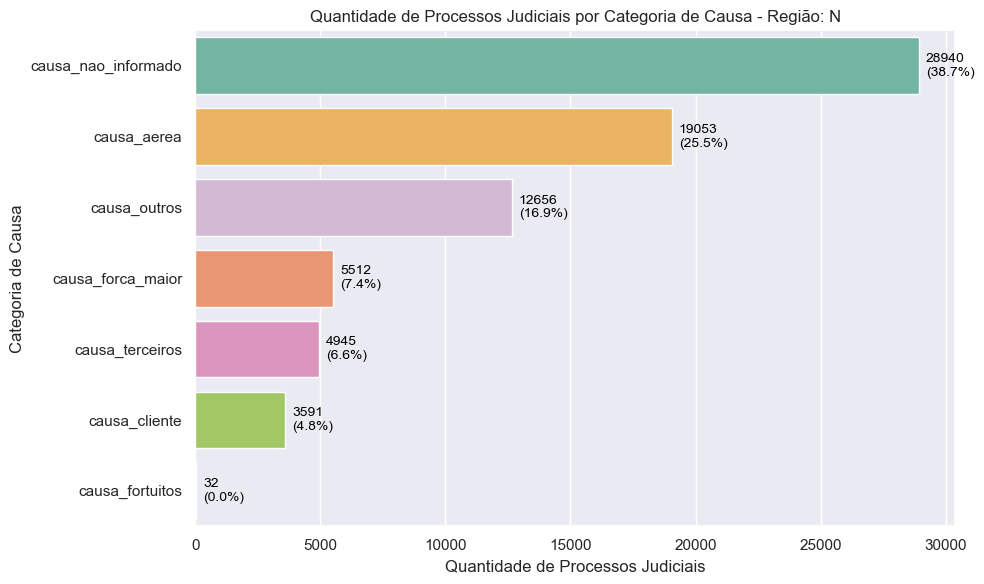

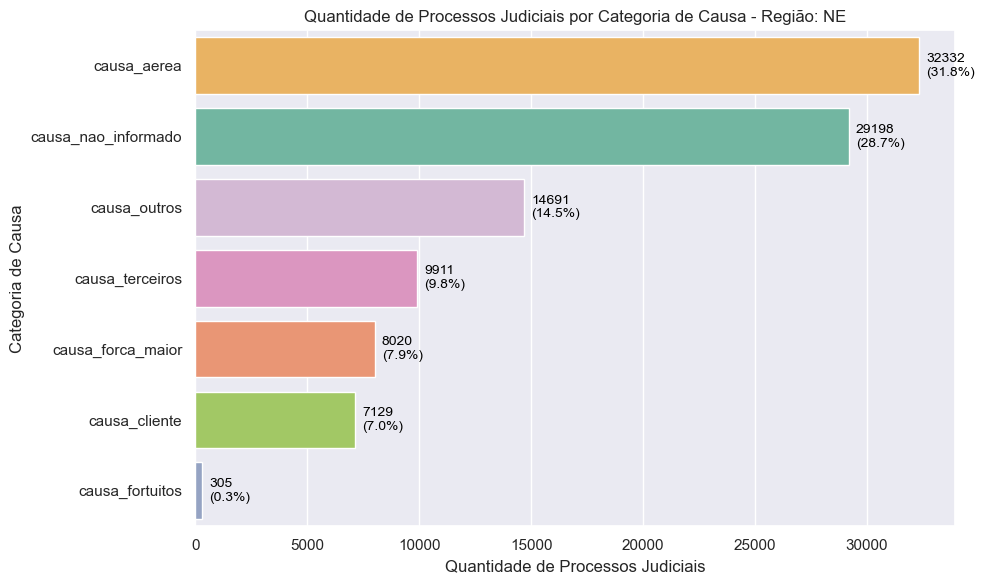

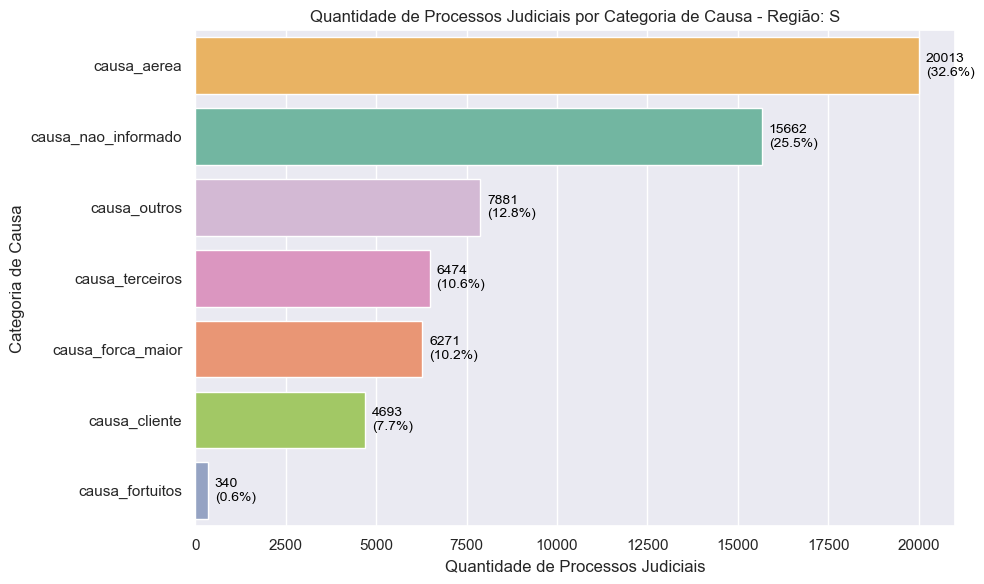

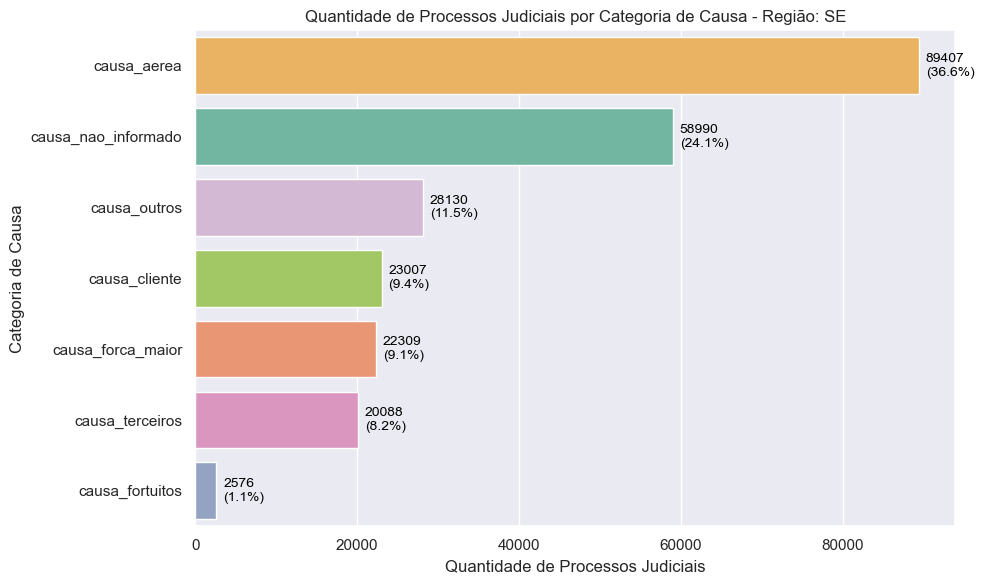

In [ ]:
# Definindo o dicionário de cores para as causas
cores_causas = {
    'causa_nao_informado': '#66C2A5',
    'causa_forca_maior': '#FC8D62',
    'causa_fortuitos': '#8DA0CB',
    'causa_terceiros': '#E78AC3',
    'causa_cliente': '#A6D854',
    'causa_aerea': '#FFB74D',
    'causa_outros': '#D7B5D8'
}

# Agrupar os dados por Região e somar as ocorrências de cada categoria de causa
processos_regiao_causa = dados_judicializacao_AED.groupby(['regiao'])[categorias_causas].sum()

# Calcular o total de processos por Região
processos_regiao_causa['Total'] = processos_regiao_causa.sum(axis=1)

# Criar um gráfico para cada região
for regiao in processos_regiao_causa.index:
    # Selecionar os dados da região
    dados_regiao = processos_regiao_causa.loc[regiao, categorias_causas]

    # Ordenar os dados da região do maior para o menor
    dados_regiao = dados_regiao.sort_values(ascending=False)  # Ordem decrescente para barras do maior para o menor

    # Plotar o gráfico de barras horizontais
    plt.figure(figsize=(10, 6))
    sns.barplot(x=dados_regiao.values, y=dados_regiao.index, palette=cores_causas, orient='h', hue=dados_regiao.index)

    # Título e rótulos
    plt.title(f'Quantidade de Processos Judiciais por Categoria de Causa - Região: {regiao}', fontsize=12)
    plt.xlabel('Quantidade de Processos Judiciais', fontsize=12)
    plt.ylabel('Categoria de Causa', fontsize=12)

    # Calcular o total de processos judiciais para a região
    total_processos_regiao = dados_regiao.sum()

    # Adicionar os valores e percentuais nas barras
    for p in plt.gca().patches:
        width = p.get_width()  # Agora é a largura, pois estamos usando barras horizontais
        percentage = (width / total_processos_regiao) * 100
        plt.gca().annotate(f'{int(width)}\n({percentage:.1f}%)',
                           (width, p.get_y() + p.get_height() / 2.),
                           ha='left', va='center', fontsize=10, color='black', xytext=(5, 0), textcoords='offset points')

    # Ajustar o layout para o gráfico
    plt.tight_layout()

    # Salvar o gráfico em formato PNG
    plt.savefig(f"processos_causa_regiao_{regiao}.png", format="png", dpi=300)

    # Exibir o gráfico
    plt.show()

In [ ]:
# Agrupar os dados por empresa e somar as ocorrências de cada categoria de motivo
processos_empresa_causa = dados_judicializacao_AED.groupby(['empresa_re'])[categorias_causas].sum()

# Calcular o total de processos judiciais por empresa
processos_empresa_causa['Total'] = processos_empresa_causa.sum(axis=1)

# Calcular o total de processos por categoria
totais_por_categoria_empresa = processos_empresa_causa[categorias_causas].sum()

# Adicionar os totais por categoria como uma linha
processos_empresa_causa.loc['Total'] = totais_por_categoria_empresa

# Adicionar o total geral (total de processos)
total_geral_empresa = processos_empresa_causa['Total'].sum()

# Transpor o DataFrame
processos_empresa_causa_transposta = processos_empresa_causa.transpose()

# Exibir a tabela
processos_empresa_causa_transposta

empresa_re               Azul     Copa       Gol     Latam      TAP  United  \
causa_nao_informado  123820.0      0.0       0.0   20309.0      0.0     0.0   
causa_forca_maior       624.0    503.0   26190.0   17574.0   1053.0   773.0   
causa_fortuitos           0.0      0.0       0.0       0.0      0.0  3404.0   
causa_terceiros         593.0      2.0   29468.0   15452.0    324.0   192.0   
causa_cliente          1078.0   1670.0    6685.0   34734.0      7.0   718.0   
causa_aerea           13514.0   3366.0   48746.0  110652.0  12266.0  2937.0   
causa_outros          67025.0   5290.0    1663.0       0.0   4817.0    97.0   
Total                206654.0  10831.0  112752.0  198721.0  18467.0  8121.0   

empresa_re              Total  
causa_nao_informado  144129.0  
causa_forca_maior     46717.0  
causa_fortuitos        3404.0  
causa_terceiros       46031.0  
causa_cliente         44892.0  
causa_aerea          191481.0  
causa_outros          78892.0  
Total                     NaN

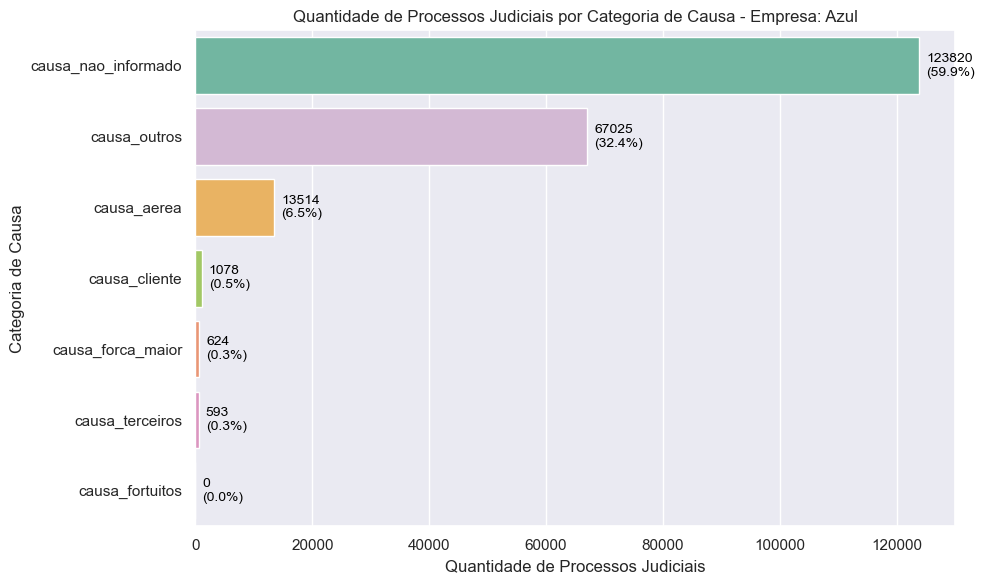

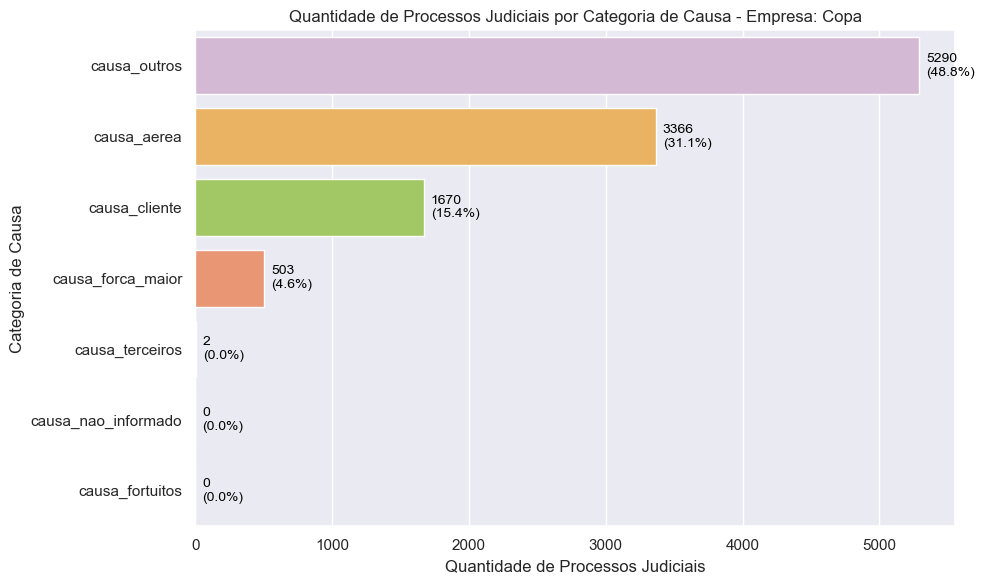

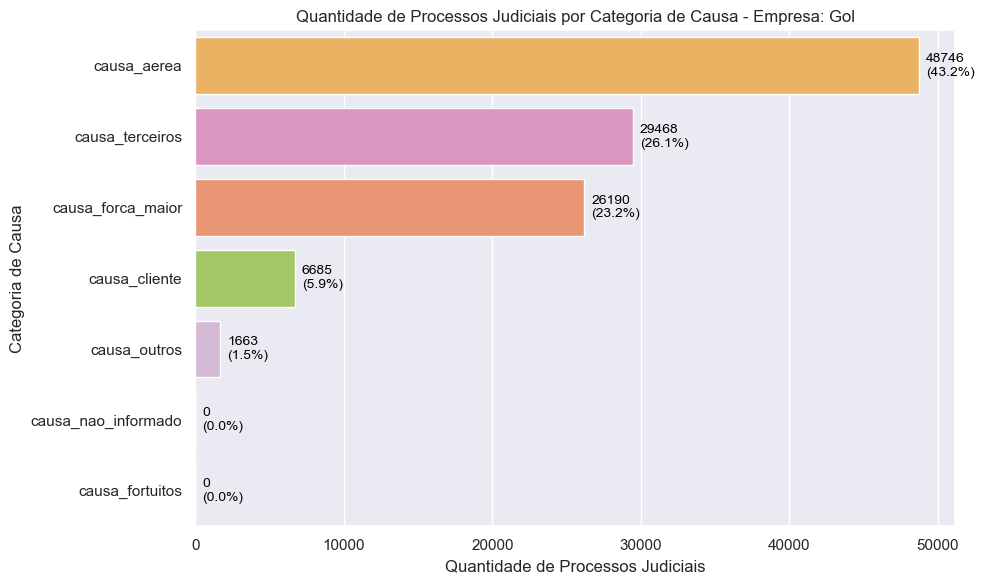

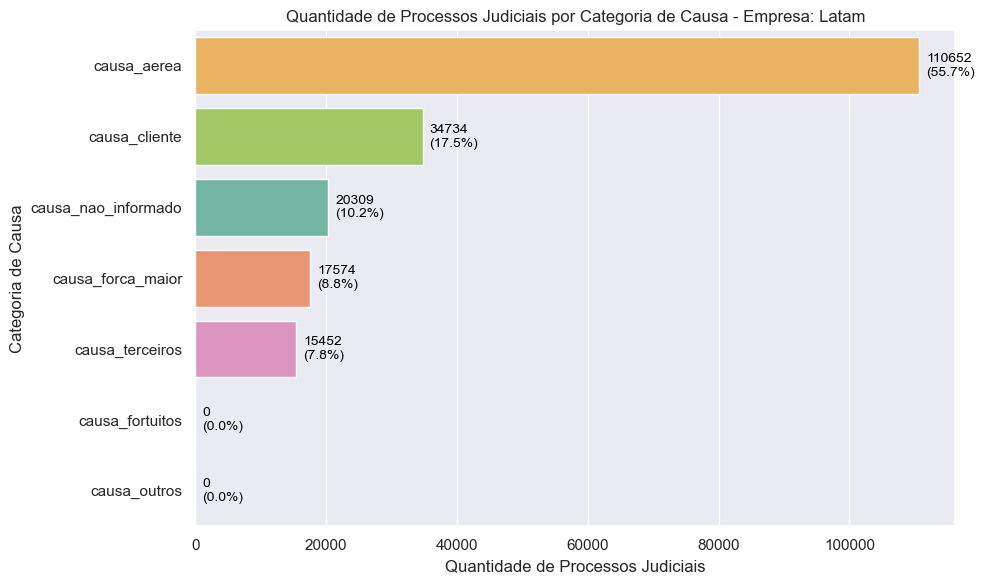

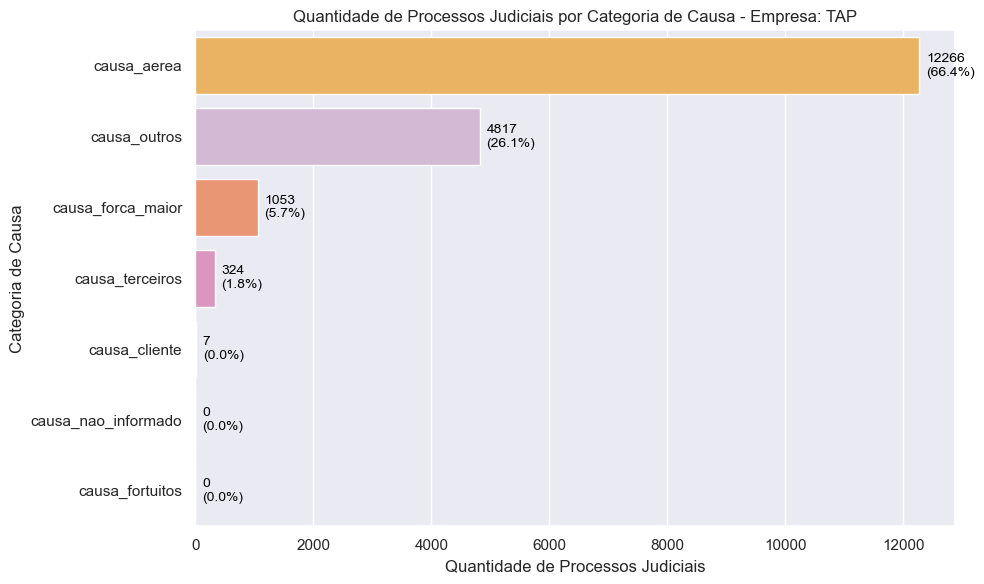

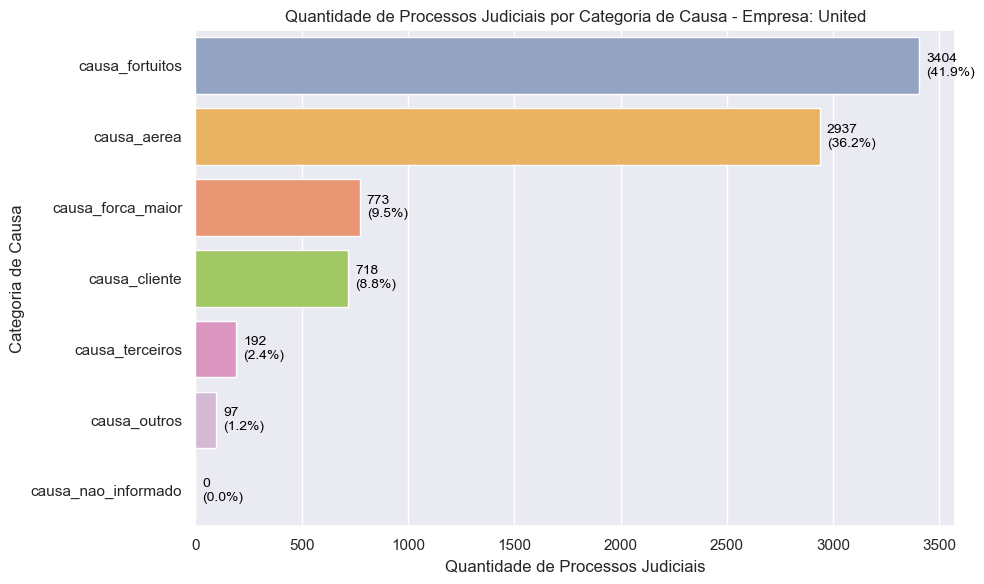

In [ ]:
# Definindo o dicionário de cores para as causas
cores_causas = {
    'causa_nao_informado': '#66C2A5',
    'causa_forca_maior': '#FC8D62',
    'causa_fortuitos': '#8DA0CB',
    'causa_terceiros': '#E78AC3',
    'causa_cliente': '#A6D854',
    'causa_aerea': '#FFB74D',
    'causa_outros': '#D7B5D8'
}

# Agrupar os dados por empresa e somar as ocorrências de cada categoria de causa
processos_empresa_causa = dados_judicializacao_AED.groupby(['empresa_re'])[categorias_causas].sum()

# Calcular o total de processos judiciais por empresa
processos_empresa_causa['Total'] = processos_empresa_causa.sum(axis=1)

# Criar um gráfico para cada empresa
for empresa in processos_empresa_causa.index:
    # Selecionar os dados da empresa
    dados_empresa = processos_empresa_causa.loc[empresa, categorias_causas]

    # Ordenar os dados da empresa do maior para o menor
    dados_empresa = dados_empresa.sort_values(ascending=False)  # Ordem decrescente para barras do maior para o menor

    # Plotar o gráfico de barras horizontais
    plt.figure(figsize=(10, 6))
    sns.barplot(x=dados_empresa.values, y=dados_empresa.index, palette=cores_causas, orient='h', hue=dados_empresa.index)

    # Título e rótulos
    plt.title(f'Quantidade de Processos Judiciais por Categoria de Causa - Empresa: {empresa}', fontsize=12)
    plt.xlabel('Quantidade de Processos Judiciais', fontsize=12)
    plt.ylabel('Categoria de Causa', fontsize=12)

    # Calcular o total de processos judiciais para a empresa
    total_processos_empresa = dados_empresa.sum()

    # Adicionar os valores e percentuais nas barras
    for p in plt.gca().patches:
        width = p.get_width()  # Agora é a largura, pois estamos usando barras horizontais
        percentage = (width / total_processos_empresa) * 100
        plt.gca().annotate(f'{int(width)}\n({percentage:.1f}%)',
                           (width, p.get_y() + p.get_height() / 2.),
                           ha='left', va='center', fontsize=10, color='black', xytext=(5, 0), textcoords='offset points')

    # Ajustar o layout para o gráfico
    plt.tight_layout()

    # Salvar o gráfico em formato PNG
    plt.savefig(f"processos_causa_empresa_{empresa}.png", format="png", dpi=300)

    # Exibir o gráfico
    plt.show()

In [ ]:
# Agrupar os dados por 'causa_alegada' e 'num_proc_ano' para contar o número de processos por causa e ano
processos_causa_ano = dados_judicializacao_AED.groupby(['obj_principal', 'subobj_principal', 'causa_alegada', 'num_proc_ano']).size().reset_index(name='Quantidade de Processos')

# Calcular os percentuais por ano para 'causa_principal' e 'subcausa_principal'
total_processos_por_ano = processos_causa_ano.groupby('num_proc_ano')['Quantidade de Processos'].transform('sum')
processos_causa_ano['Percentual (%)'] = (processos_causa_ano['Quantidade de Processos'] / total_processos_por_ano) * 100

# Incluir as colunas para as categorias de causa (como 'causa_nao_informado', 'causa_forca_maior', etc.) para ver a classificação
processos_causa_ano = processos_causa_ano.merge(dados_judicializacao_AED[['obj_principal', 'subobj_principal', 'causa_alegada', 'num_proc_ano',
                                                                          'causa_nao_informado', 'causa_forca_maior', 'causa_fortuitos',
                                                                          'causa_terceiros', 'causa_cliente', 'causa_aerea', 'causa_outros']].drop_duplicates(),
                                                                           on=['obj_principal', 'subobj_principal', 'causa_alegada', 'num_proc_ano',], how='left')

# Selecionar o top 5 por ano
top_5_por_ano = []
for ano in processos_causa_ano['num_proc_ano'].unique():
    top_5_ano = processos_causa_ano[processos_causa_ano['num_proc_ano'] == ano] \
                    .sort_values(by='Quantidade de Processos', ascending=False) \
                    .head(5)  # Seleciona os 5 maiores com base no número de processos
    top_5_por_ano.append(top_5_ano)

# Concatenar todos os top 5 por ano em um único DataFrame
top_5_df_causas = pd.concat(top_5_por_ano)

# Reorganizar as colunas no formato desejado
top_5_df_causas = top_5_df_causas[['obj_principal', 'subobj_principal', 'causa_alegada', 'num_proc_ano', 'Quantidade de Processos', 'Percentual (%)',
                                     'causa_nao_informado', 'causa_forca_maior', 'causa_fortuitos', 'causa_terceiros', 'causa_cliente',
                                     'causa_aerea', 'causa_outros']]

# Salvar o DataFrame top_5_df_causas em um arquivo Excel
top_5_df_causas.to_excel('top_5_processos_por_ano_com_classificacao_causas.xlsx', index=False)

# Exibir o resultado final
top_5_df_causas

obj_principal          subobj_principal  \
1527  CANCELAMENTO DE VOO                       ***   
620        Atraso de vÃ´o                       ***   
1517  CANCELAMENTO DE VOO                       ***   
1479         CANCELAMENTO                  COVID-19   
1094              BAGAGEM       Extravio Temporário   
1480         CANCELAMENTO                  COVID-19   
1528  CANCELAMENTO DE VOO                       ***   
116    ALTERAÃÃO DE VOO                       ***   
1444         CANCELAMENTO    CANC. V. - MALHA AÉREA   
621        Atraso de vÃ´o                       ***   
1529  CANCELAMENTO DE VOO                       ***   
622        Atraso de vÃ´o                       ***   
117    ALTERAÃÃO DE VOO                       ***   
1481         CANCELAMENTO                  COVID-19   
1096              BAGAGEM       Extravio Temporário   
1526  CANCELAMENTO DE VOO                       ***   
619        Atraso de vÃ´o                       ***   
287                ATRASO   ATR. V. - TRÁFEGO AÉREO   
114    ALTERAÃÃO DE VOO                       ***   
1457         CANCELAMENTO  CANC. V. - TRÁFEGO AÉREO   
652         Atraso de vôo                       ***   
1530  CANCELAMENTO DE VOO                       ***   
291                ATRASO   ATR. V. - TRÁFEGO AÉREO   
143      ALTERAÇÃO DE VOO                       ***   
1520  CANCELAMENTO DE VOO                       ***   

                  causa_alegada  num_proc_ano  Quantidade de Processos  \
1527                  Culpa Tam          2020                     5326   
620                   Culpa Tam          2020                     4030   
1517  Caso fortuito/força Maior          2020                     2712   
1479                          -          2020                     1603   
1094                  Culpa Tam          2020                     1589   
1480                          -          2021                     5537   
1528                  Culpa Tam          2021                     4810   
116                   Culpa Tam          2021                     2906   
1444                          -          2021                     2565   
621                   Culpa Tam          2021                     2088   
1529                  Culpa Tam          2022                     8729   
622                   Culpa Tam          2022                     4877   
117                   Culpa Tam          2022                     3165   
1481                          -          2022                     3034   
1096                  Culpa Tam          2022                     2976   
1526                  Culpa Tam          2019                     8628   
619                   Culpa Tam          2019                     7311   
287                           -          2019                     3864   
114                   Culpa Tam          2019                     2868   
1457                          -          2019                     2784   
652                   Culpa Tam          2023                    10680   
1530                  Culpa Tam          2023                     9963   
291                           -          2023                     5278   
143                   Culpa Tam          2023                     4018   
1520  Caso fortuito/força Maior          2023                     3849   

      Percentual (%)  causa_nao_informado  causa_forca_maior  causa_fortuitos  \
1527       11.053921                False              False            False   
620         8.364119                False              False            False   
1517        5.628658                False               True            False   
1479        3.326969                False               True            False   
1094        3.297912                False              False            False   
1480       11.159032                False               True            False   
1528        9.693867                False              False            False   
116     

##### INDENIZAÇÕES

In [ ]:
# Definir as categorias de motivos
categorias_motivos = ['obj_problemas_operacionais', 'obj_bagagem', 'obj_contrato', 'obj_outros']

# Criar uma coluna que conta a qtd de motivos
dados_judicializacao_AED['total_motivos'] = dados_judicializacao_AED[categorias_motivos].sum(axis=1)

# Identificar o motivo predominante
dados_judicializacao_AED['motivo_predominante'] = dados_judicializacao_AED[categorias_motivos].idxmax(axis=1)

In [ ]:
# Definir as categorias de causas
categorias_causas = ['causa_nao_informado', 'causa_forca_maior', 'causa_fortuitos', 'causa_terceiros', 'causa_cliente', 'causa_aerea', 'causa_outros']

# Criar uma coluna que conta a qtd de motivos
dados_judicializacao_AED['total_causas'] = dados_judicializacao_AED[categorias_causas].sum(axis=1)

# Identificar o motivo predominante
dados_judicializacao_AED['causa_predominante'] = dados_judicializacao_AED[categorias_causas].idxmax(axis=1)

###### Valor pedido inicial

In [ ]:
# Filtra o DataFrame para excluir os zeros na coluna 'valor_pedido_inicial'
dados_sem_zero_pedido_inicial = dados_judicializacao_AED[dados_judicializacao_AED['valor_pedido_inicial'] != 0]

# Calcula o valor mínimo da coluna 'valor_pedido_inicial', desconsiderando os zeros
valor_minimo_pedido_inicial = dados_sem_zero_pedido_inicial['valor_pedido_inicial'].min()

# Exibe o resultado
print("\nValor Mínimo da Coluna 'valor_pedido_inicial' (Sem Zeros):")
print(valor_minimo_pedido_inicial)


Valor Mínimo da Coluna 'valor_pedido_inicial' (Sem Zeros):
0.01


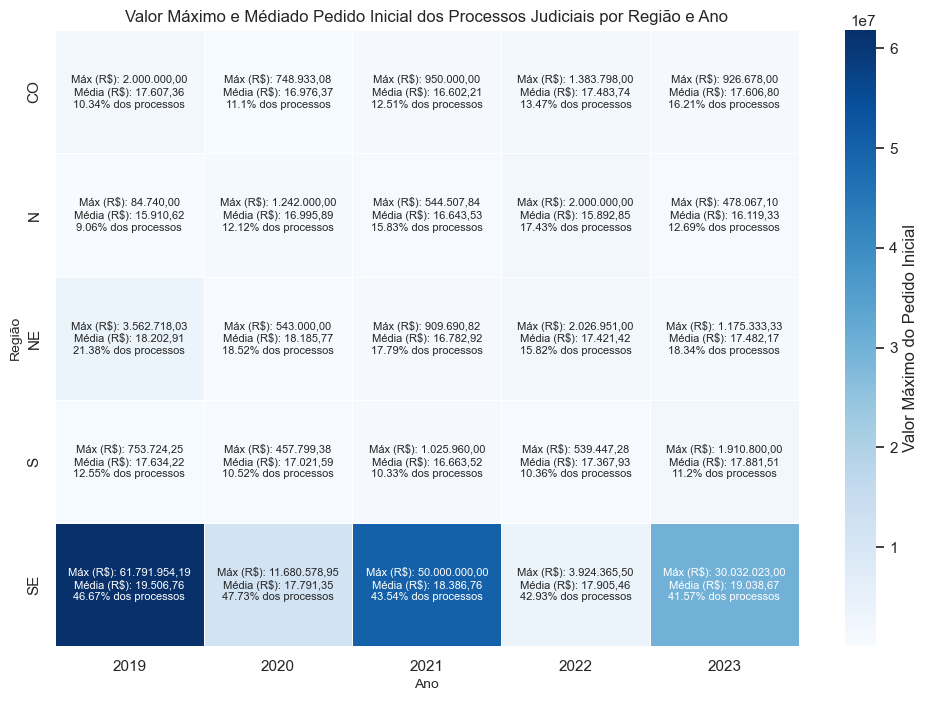

In [ ]:
# Agrupar por ano (num_proc_ano) e região (regiao), e calcular o valor máximo, média e contagem de processos
agg_data = dados_judicializacao_AED.groupby(['num_proc_ano', 'regiao'])['valor_pedido_inicial'].agg(['max', 'mean', 'count']).reset_index()

# Calcular o total de processos por ano
total_processos_ano = dados_judicializacao_AED.groupby('num_proc_ano')['valor_pedido_inicial'].count().reset_index(name='total_processos_ano')

# Mesclar o total de processos por ano com o agg_data
agg_data = pd.merge(agg_data, total_processos_ano, on='num_proc_ano')

# Calcular o percentual de processos
agg_data['percentual_processos'] = (agg_data['count'] / agg_data['total_processos_ano']) * 100

# Criar uma nova coluna para armazenar os textos formatados que irão aparecer no heatmap
agg_data['texto'] = ('Máx (R$): ' + agg_data['max'].apply(lambda x: f'{x:,.2f}'.replace(',', 'X').replace('.', ',').replace('X', '.')) + '\n' +
                     'Média (R$): ' + agg_data['mean'].apply(lambda x: f'{x:,.2f}'.replace(',', 'X').replace('.', ',').replace('X', '.')) + '\n' +
                     agg_data['percentual_processos'].round(2).astype(str) + '% dos processos')

# Pivotar os dados para que os anos fiquem nas colunas e as regiões nas linhas
heatmap_data = agg_data.pivot(index='regiao', columns='num_proc_ano', values='max')
texto_data = agg_data.pivot(index='regiao', columns='num_proc_ano', values='texto')

# Criar o heatmap com ajuste de tamanho do texto
plt.figure(figsize=(12, 8))  # Tamanho do gráfico
sns.heatmap(heatmap_data, cmap='Blues', annot=texto_data, fmt="",
            annot_kws={'size': 8},  # Ajustar o tamanho do texto
            cbar_kws={'label': 'Valor Máximo do Pedido Inicial'}, linewidths=0.5)

# Adicionar título e rótulos aos eixos
plt.title('Valor Máximo e Médiado Pedido Inicial dos Processos Judiciais por Região e Ano', fontsize=12)
plt.xlabel('Ano', fontsize=10)
plt.ylabel('Região', fontsize=10)

# Salvar o gráfico em formato PNG
plt.savefig(f"pedido_inicial_ano_regiao.png", format="png", dpi=300)

# Exibir o gráfico
plt.show()

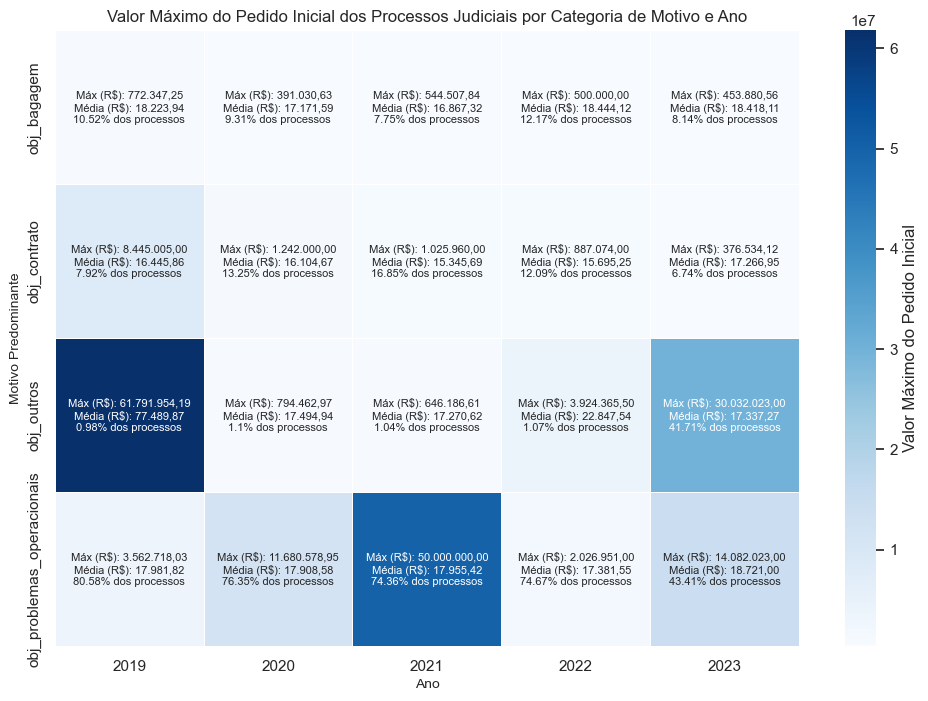

In [ ]:
# Agrupar por ano (num_proc_ano) e motivo (motivo_predominante)
agg_data = dados_judicializacao_AED.groupby(['num_proc_ano', 'motivo_predominante'])['valor_pedido_inicial'].agg(['max', 'mean', 'count']).reset_index()

# Calcular o total de processos por ano
total_processos_ano = dados_judicializacao_AED.groupby('num_proc_ano')['valor_pedido_inicial'].count().reset_index(name='total_processos_ano')

# Mesclar o total de processos por ano com o agg_data
agg_data = pd.merge(agg_data, total_processos_ano, on='num_proc_ano')

# Calcular o percentual de processos
agg_data['percentual_processos'] = (agg_data['count'] / agg_data['total_processos_ano']) * 100

# Criar uma nova coluna para armazenar os textos formatados que irão aparecer no heatmap
agg_data['texto'] = ('Máx (R$): ' + agg_data['max'].apply(lambda x: f'{x:,.2f}'.replace(',', 'X').replace('.', ',').replace('X', '.')) + '\n' +
                     'Média (R$): ' + agg_data['mean'].apply(lambda x: f'{x:,.2f}'.replace(',', 'X').replace('.', ',').replace('X', '.')) + '\n' +
                     agg_data['percentual_processos'].round(2).astype(str) + '% dos processos')

# Usar pivot_table para permitir agregação automática caso haja duplicação
heatmap_data = agg_data.pivot_table(index='motivo_predominante', columns='num_proc_ano', values='max', aggfunc='max')
texto_data = agg_data.pivot_table(index='motivo_predominante', columns='num_proc_ano', values='texto', aggfunc='first')  # 'first' para pegar o primeiro texto caso haja duplicatas

# Criar o heatmap com ajuste de tamanho do texto
plt.figure(figsize=(12, 8))  # Tamanho do gráfico
sns.heatmap(heatmap_data, cmap='Blues', annot=texto_data, fmt="",
            annot_kws={'size': 8},  # Ajustar o tamanho do texto
            cbar_kws={'label': 'Valor Máximo do Pedido Inicial'}, linewidths=0.5)

# Adicionar título e rótulos aos eixos
plt.title('Valor Máximo do Pedido Inicial dos Processos Judiciais por Categoria de Motivo e Ano', fontsize=12)
plt.xlabel('Ano', fontsize=10)
plt.ylabel('Motivo Predominante', fontsize=10)

# Salvar o gráfico em formato PNG
plt.savefig(f"pedido_inicial_ano_motivo.png", format="png", dpi=300)

# Exibir o gráfico
plt.show()

###### Valor dano moral

In [ ]:
# Filtra o DataFrame para excluir os zeros na coluna 'valor_dano_moral'
dados_sem_zero_dano_moral = dados_judicializacao_AED[dados_judicializacao_AED['valor_dano_moral'] != 0]

# Calcula o valor mínimo da coluna 'valor_dano_moral', desconsiderando os zeros
valor_minimo_dano_moral = dados_sem_zero_dano_moral['valor_dano_moral'].min()

# Exibe o resultado
print("\nValor Mínimo da Coluna 'valor_dano_moral' (Sem Zeros):")
print(valor_minimo_dano_moral)


Valor Mínimo da Coluna 'valor_dano_moral' (Sem Zeros):
0.01


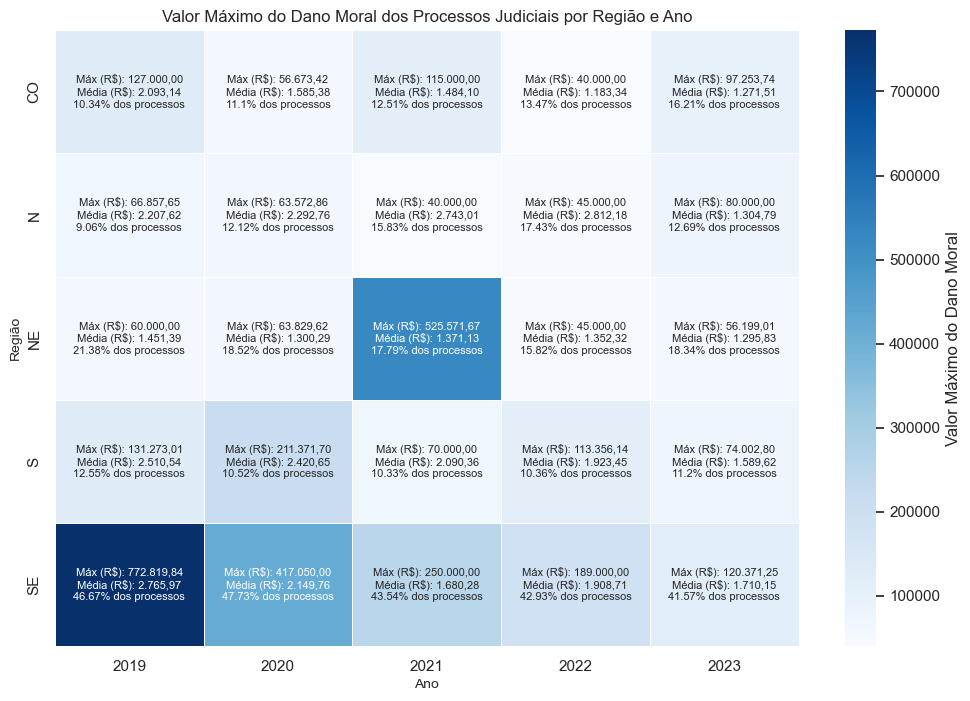

In [ ]:
# Agrupar por ano (num_proc_ano) e região (regiao), e calcular o valor máximo, média e contagem de processos
agg_data = dados_judicializacao_AED.groupby(['num_proc_ano', 'regiao'])['valor_dano_moral'].agg(['max', 'mean', 'count']).reset_index()

# Calcular o total de processos por ano
total_processos_ano = dados_judicializacao_AED.groupby('num_proc_ano')['valor_dano_moral'].count().reset_index(name='total_processos_ano')

# Mesclar o total de processos por ano com o agg_data
agg_data = pd.merge(agg_data, total_processos_ano, on='num_proc_ano')

# Calcular o percentual de processos
agg_data['percentual_processos'] = (agg_data['count'] / agg_data['total_processos_ano']) * 100

# Criar uma nova coluna para armazenar os textos formatados que irão aparecer no heatmap
agg_data['texto'] = ('Máx (R$): ' + agg_data['max'].apply(lambda x: f'{x:,.2f}'.replace(',', 'X').replace('.', ',').replace('X', '.')) + '\n' +
                     'Média (R$): ' + agg_data['mean'].apply(lambda x: f'{x:,.2f}'.replace(',', 'X').replace('.', ',').replace('X', '.')) + '\n' +
                     agg_data['percentual_processos'].round(2).astype(str) + '% dos processos')

# Pivotar os dados para que os anos fiquem nas colunas e as regiões nas linhas
heatmap_data = agg_data.pivot(index='regiao', columns='num_proc_ano', values='max')
texto_data = agg_data.pivot(index='regiao', columns='num_proc_ano', values='texto')

# Criar o heatmap com ajuste de tamanho do texto
plt.figure(figsize=(12, 8))  # Tamanho do gráfico
sns.heatmap(heatmap_data, cmap='Blues', annot=texto_data, fmt="",
            annot_kws={'size': 8},  # Ajustar o tamanho do texto
            cbar_kws={'label': 'Valor Máximo do Dano Moral'}, linewidths=0.5)

# Adicionar título e rótulos aos eixos
plt.title('Valor Máximo do Dano Moral dos Processos Judiciais por Região e Ano', fontsize=12)
plt.xlabel('Ano', fontsize=10)
plt.ylabel('Região', fontsize=10)

# Salvar o gráfico em formato PNG
plt.savefig(f"dano_moral_ano_regiao.png", format="png", dpi=300)

# Exibir o gráfico
plt.show()

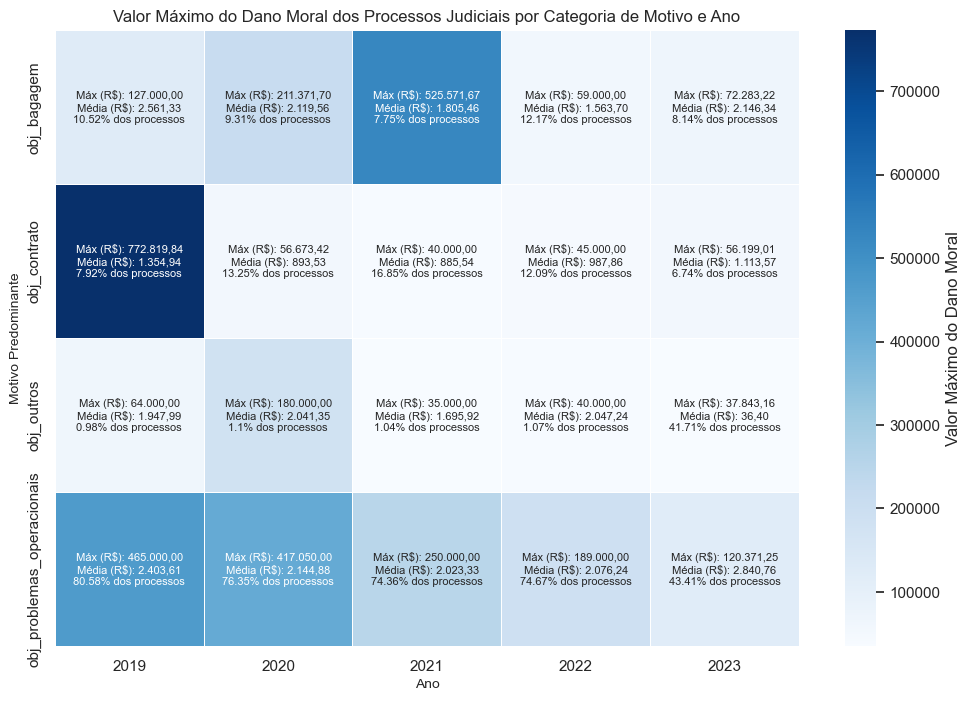

In [ ]:
# Agrupar por ano (num_proc_ano) e motivo (motivo_predominante)
agg_data = dados_judicializacao_AED.groupby(['num_proc_ano', 'motivo_predominante'])['valor_dano_moral'].agg(['max', 'mean', 'count']).reset_index()

# Calcular o total de processos por ano
total_processos_ano = dados_judicializacao_AED.groupby('num_proc_ano')['valor_dano_moral'].count().reset_index(name='total_processos_ano')

# Mesclar o total de processos por ano com o agg_data
agg_data = pd.merge(agg_data, total_processos_ano, on='num_proc_ano')

# Calcular o percentual de processos
agg_data['percentual_processos'] = (agg_data['count'] / agg_data['total_processos_ano']) * 100

# Criar uma nova coluna para armazenar os textos formatados que irão aparecer no heatmap
agg_data['texto'] = ('Máx (R$): ' + agg_data['max'].apply(lambda x: f'{x:,.2f}'.replace(',', 'X').replace('.', ',').replace('X', '.')) + '\n' +
                     'Média (R$): ' + agg_data['mean'].apply(lambda x: f'{x:,.2f}'.replace(',', 'X').replace('.', ',').replace('X', '.')) + '\n' +
                     agg_data['percentual_processos'].round(2).astype(str) + '% dos processos')

# Usar pivot_table para permitir agregação automática caso haja duplicação
heatmap_data = agg_data.pivot_table(index='motivo_predominante', columns='num_proc_ano', values='max', aggfunc='max')
texto_data = agg_data.pivot_table(index='motivo_predominante', columns='num_proc_ano', values='texto', aggfunc='first')  # 'first' para pegar o primeiro texto caso haja duplicatas

# Criar o heatmap com ajuste de tamanho do texto
plt.figure(figsize=(12, 8))  # Tamanho do gráfico
sns.heatmap(heatmap_data, cmap='Blues', annot=texto_data, fmt="",
            annot_kws={'size': 8},  # Ajustar o tamanho do texto
            cbar_kws={'label': 'Valor Máximo do Dano Moral'}, linewidths=0.5)

# Adicionar título e rótulos aos eixos
plt.title('Valor Máximo do Dano Moral dos Processos Judiciais por Categoria de Motivo e Ano', fontsize=12)
plt.xlabel('Ano', fontsize=10)
plt.ylabel('Motivo Predominante', fontsize=10)

# Salvar o gráfico em formato PNG
plt.savefig(f"dano_moral_ano_motivo.png", format="png", dpi=300)

# Exibir o gráfico
plt.show()

In [ ]:
# Filtrar os dados para o ano de 2023, operação doméstica e situação processual e setença de condenação
filtro = (dados_judicializacao_AED['num_proc_ano'] == 2023) & (dados_judicializacao_AED['operacao'] == 'Doméstico') & (dados_judicializacao_AED['situacao_processual_sentenca'] == 'Condenação')

# Aplicar o filtro e calcular a média
media_valor_dano_moral = dados_judicializacao_AED.loc[filtro, 'valor_dano_moral'].mean()

print(f"A média de valor_dano_moral em 2023 para voos de operação doméstica é: {media_valor_dano_moral:.2f}")

A média de valor_dano_moral em 2023 para voos de operação doméstica é: 4229.88


###### Valor dano material

In [ ]:
# Filtra o DataFrame para excluir os zeros na coluna 'valor_dano_material'
dados_sem_zero_dano_material = dados_judicializacao_AED[dados_judicializacao_AED['valor_dano_material'] != 0]

# Calcula o valor mínimo da coluna 'valor_dano_material', desconsiderando os zeros
valor_minimo_dano_material = dados_sem_zero_dano_material['valor_dano_material'].min()

# Exibe o resultado
print("\nValor Mínimo da Coluna 'valor_dano_material' (Sem Zeros):")
print(valor_minimo_dano_material)


Valor Mínimo da Coluna 'valor_dano_material' (Sem Zeros):
0.01


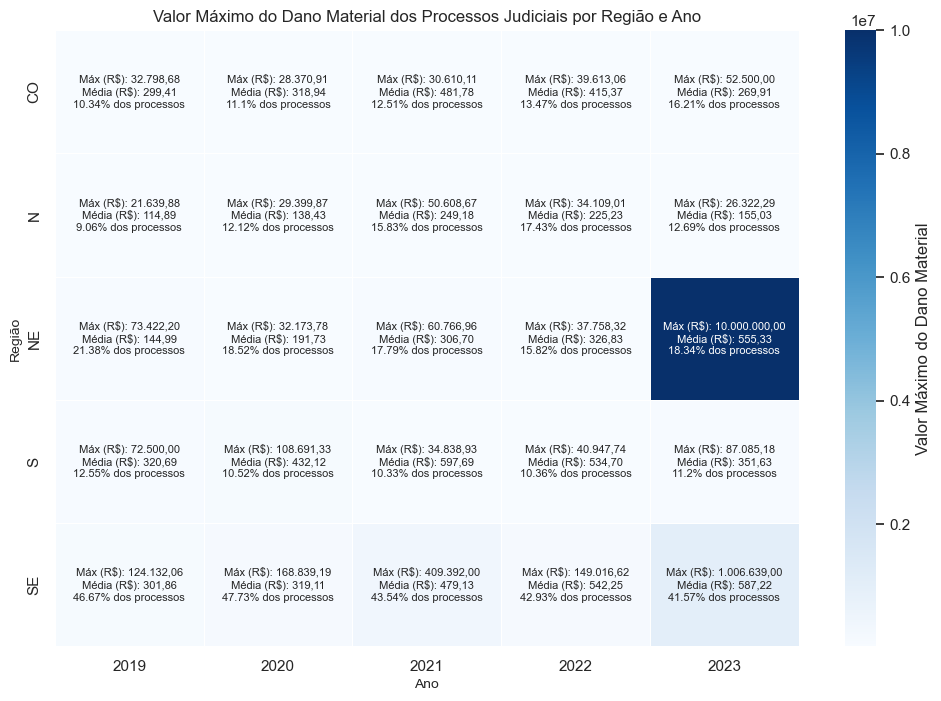

In [ ]:
# Agrupar por ano (num_proc_ano) e região (regiao), e calcular o valor máximo, média e contagem de processos
agg_data = dados_judicializacao_AED.groupby(['num_proc_ano', 'regiao'])['valor_dano_material'].agg(['max', 'mean', 'count']).reset_index()

# Calcular o total de processos por ano
total_processos_ano = dados_judicializacao_AED.groupby('num_proc_ano')['valor_dano_material'].count().reset_index(name='total_processos_ano')

# Mesclar o total de processos por ano com o agg_data
agg_data = pd.merge(agg_data, total_processos_ano, on='num_proc_ano')

# Calcular o percentual de processos
agg_data['percentual_processos'] = (agg_data['count'] / agg_data['total_processos_ano']) * 100

# Criar uma nova coluna para armazenar os textos formatados que irão aparecer no heatmap
agg_data['texto'] = ('Máx (R$): ' + agg_data['max'].apply(lambda x: f'{x:,.2f}'.replace(',', 'X').replace('.', ',').replace('X', '.')) + '\n' +
                     'Média (R$): ' + agg_data['mean'].apply(lambda x: f'{x:,.2f}'.replace(',', 'X').replace('.', ',').replace('X', '.')) + '\n' +
                     agg_data['percentual_processos'].round(2).astype(str) + '% dos processos')

# Pivotar os dados para que os anos fiquem nas colunas e as regiões nas linhas
heatmap_data = agg_data.pivot(index='regiao', columns='num_proc_ano', values='max')
texto_data = agg_data.pivot(index='regiao', columns='num_proc_ano', values='texto')

# Criar o heatmap com ajuste de tamanho do texto
plt.figure(figsize=(12, 8))  # Tamanho do gráfico
sns.heatmap(heatmap_data, cmap='Blues', annot=texto_data, fmt="",
            annot_kws={'size': 8},  # Ajustar o tamanho do texto
            cbar_kws={'label': 'Valor Máximo do Dano Material'}, linewidths=0.5)

# Adicionar título e rótulos aos eixos
plt.title('Valor Máximo do Dano Material dos Processos Judiciais por Região e Ano', fontsize=12)
plt.xlabel('Ano', fontsize=10)
plt.ylabel('Região', fontsize=10)

# Salvar o gráfico em formato PNG
plt.savefig(f"dano_material_ano_regiao.png", format="png", dpi=300)

# Exibir o gráfico
plt.show()

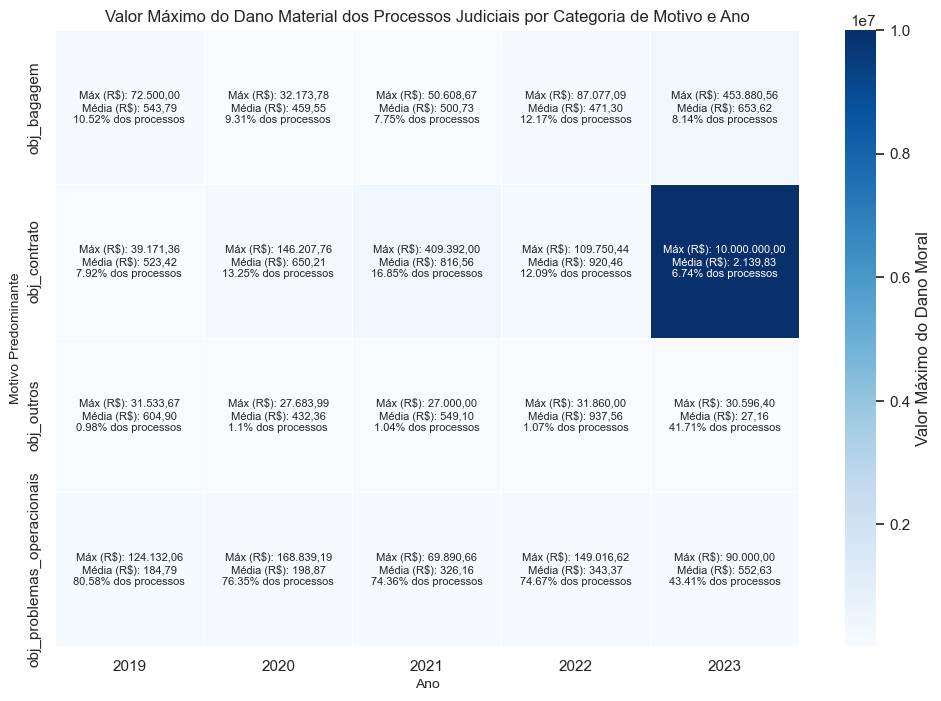

In [ ]:
# Agrupar por ano (num_proc_ano) e motivo (motivo_predominante)
agg_data = dados_judicializacao_AED.groupby(['num_proc_ano', 'motivo_predominante'])['valor_dano_material'].agg(['max', 'mean', 'count']).reset_index()

# Calcular o total de processos por ano
total_processos_ano = dados_judicializacao_AED.groupby('num_proc_ano')['valor_dano_material'].count().reset_index(name='total_processos_ano')

# Mesclar o total de processos por ano com o agg_data
agg_data = pd.merge(agg_data, total_processos_ano, on='num_proc_ano')

# Calcular o percentual de processos
agg_data['percentual_processos'] = (agg_data['count'] / agg_data['total_processos_ano']) * 100

# Criar uma nova coluna para armazenar os textos formatados que irão aparecer no heatmap
agg_data['texto'] = ('Máx (R$): ' + agg_data['max'].apply(lambda x: f'{x:,.2f}'.replace(',', 'X').replace('.', ',').replace('X', '.')) + '\n' +
                     'Média (R$): ' + agg_data['mean'].apply(lambda x: f'{x:,.2f}'.replace(',', 'X').replace('.', ',').replace('X', '.')) + '\n' +
                     agg_data['percentual_processos'].round(2).astype(str) + '% dos processos')

# Usar pivot_table para permitir agregação automática caso haja duplicação
heatmap_data = agg_data.pivot_table(index='motivo_predominante', columns='num_proc_ano', values='max', aggfunc='max')
texto_data = agg_data.pivot_table(index='motivo_predominante', columns='num_proc_ano', values='texto', aggfunc='first')  # 'first' para pegar o primeiro texto caso haja duplicatas

# Criar o heatmap com ajuste de tamanho do texto
plt.figure(figsize=(12, 8))  # Tamanho do gráfico
sns.heatmap(heatmap_data, cmap='Blues', annot=texto_data, fmt="",
            annot_kws={'size': 8},  # Ajustar o tamanho do texto
            cbar_kws={'label': 'Valor Máximo do Dano Moral'}, linewidths=0.5)

# Adicionar título e rótulos aos eixos
plt.title('Valor Máximo do Dano Material dos Processos Judiciais por Categoria de Motivo e Ano', fontsize=12)
plt.xlabel('Ano', fontsize=10)
plt.ylabel('Motivo Predominante', fontsize=10)

# Salvar o gráfico em formato PNG
plt.savefig(f"dano_material_ano_motivo.png", format="png", dpi=300)

# Exibir o gráfico
plt.show()

In [ ]:
# Aplicar o filtro e calcular a média
media_valor_dano_material = dados_judicializacao_AED.loc[filtro, 'valor_dano_material'].mean()

print(f"A média de valor_dano_material em 2023 para voos de operação doméstica é: {media_valor_dano_material:.2f}")

A média de valor_dano_material em 2023 para voos de operação doméstica é: 924.20


###### Valor total condenação

In [ ]:
# Filtrando apenas os processos que podem ter valor total de condenação e valor pago
dados_judicializacao_AED_filtro = dados_judicializacao_AED[
    dados_judicializacao_AED['situacao_processual_sentenca'].isin(['Acordo', 'Condenação', 'Outros'])
]

In [ ]:
# Descrição estatística das variáveis numéricas
print("\nEstatísticas Descritivas - Variáveis Numéricas:")
dados_judicializacao_AED_filtro.describe()


Estatísticas Descritivas - Variáveis Numéricas:


num_proc_ano      n_autores  valor_pedido_inicial  valor_dano_moral  \
count  511398.000000  511398.000000          5.113980e+05     511398.000000   
mean     2021.328191       1.078798          1.788794e+04       2013.219441   
min      2019.000000       0.000000          0.000000e+00          0.000000   
25%      2020.000000       1.000000          1.000000e+04          0.000000   
50%      2022.000000       1.000000          1.500000e+04          0.000000   
75%      2023.000000       1.000000          2.076045e+04       3000.000000   
max      2023.000000      61.000000          6.179195e+07     772819.840000   
std         1.494119       0.803387          1.232227e+05       4178.471196   

       valor_dano_material  valor_total_condenacao    valor_pago  \
count         5.113980e+05            5.113980e+05  5.113980e+05   
mean          4.118555e+02            1.625988e+03  2.307234e+03   
min           0.000000e+00            0.000000e+00  0.000000e+00   
25%           0.000000e+00            0.000000e+00  0.000000e+00   
50%           0.000000e+00            0.000000e+00  0.000000e+00   
75%           0.000000e+00            1.751007e+03  3.228053e+03   
max           1.000000e+07            1.188888e+06  7.889160e+06   
std           1.420242e+04            5.163230e+03  1.269524e+04   

       mes_distribuicao                    data_voo_dt  \
count     511398.000000                         383810   
mean           6.431087  2021-03-27 02:05:53.837576448   
min            0.000000            1901-12-31 00:00:00   
25%            3.000000            2019-11-14 00:00:00   
50%            6.000000            2021-05-31 00:00:00   
75%           10.000000            2022-08-09 00:00:00   
max           12.000000            2202-12-04 00:00:00   
std            3.491155                            NaN   

                data_distribuicao_dt  intervalo_meses  total_motivos  \
count                         510429    383801.000000  511398.000000   
mean   2021-10-29 04:49:09.772837120         5.336106       1.066653   
min              2001-01-01 00:00:00     -2188.000000       1.000000   
25%              2020-04-21 00:00:00         1.000000       1.000000   
50%              2022-02-21 00:00:00         2.000000       1.000000   
75%              2023-03-14 00:00:00         6.000000       1.000000   
max              2024-07-23 00:00:00      1485.000000       3.000000   
std                              NaN        13.589101       0.250023   

       total_causas  
count      511398.0  
mean            1.0  
min             1.0  
25%             1.0  
50%             1.0  
75%             1.0  
max             1.0  
std             0.0

In [ ]:
# Filtra o DataFrame para excluir os zeros na coluna 'valor_total_condenacao'
dados_sem_zero_total_condenacao = dados_judicializacao_AED_filtro[dados_judicializacao_AED_filtro['valor_total_condenacao'] != 0]

# Calcula o valor mínimo da coluna 'valor_total_condenacao', desconsiderando os zeros
valor_minimo_total_condenacao = dados_sem_zero_total_condenacao['valor_total_condenacao'].min()

# Exibe o resultado
print("\nValor Mínimo da Coluna 'valor_total_condenacao' (Sem Zeros):")
print(valor_minimo_total_condenacao)


Valor Mínimo da Coluna 'valor_total_condenacao' (Sem Zeros):
0.01


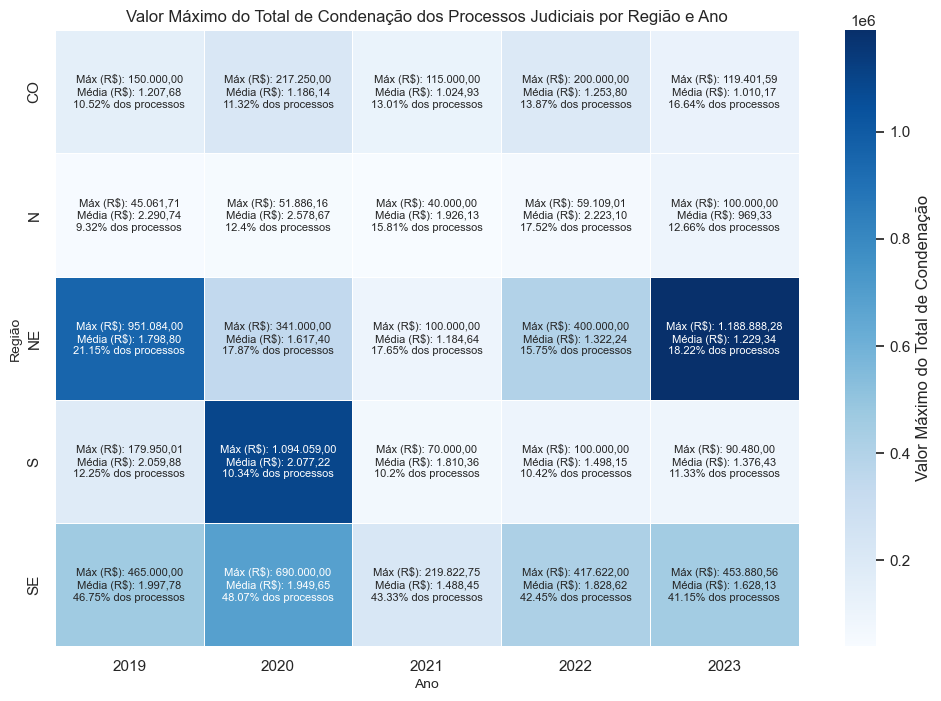

In [ ]:
# Agrupar por ano (num_proc_ano) e região (regiao), e calcular o valor máximo, média e contagem de processos
agg_data = dados_judicializacao_AED_filtro.groupby(['num_proc_ano', 'regiao'])['valor_total_condenacao'].agg(['max', 'mean', 'count']).reset_index()

# Calcular o total de processos por ano
total_processos_ano = dados_judicializacao_AED_filtro.groupby('num_proc_ano')['valor_total_condenacao'].count().reset_index(name='total_processos_ano')

# Mesclar o total de processos por ano com o agg_data
agg_data = pd.merge(agg_data, total_processos_ano, on='num_proc_ano')

# Calcular o percentual de processos
agg_data['percentual_processos'] = (agg_data['count'] / agg_data['total_processos_ano']) * 100

# Criar uma nova coluna para armazenar os textos formatados que irão aparecer no heatmap
agg_data['texto'] = ('Máx (R$): ' + agg_data['max'].apply(lambda x: f'{x:,.2f}'.replace(',', 'X').replace('.', ',').replace('X', '.')) + '\n' +
                     'Média (R$): ' + agg_data['mean'].apply(lambda x: f'{x:,.2f}'.replace(',', 'X').replace('.', ',').replace('X', '.')) + '\n' +
                     agg_data['percentual_processos'].round(2).astype(str) + '% dos processos')

# Pivotar os dados para que os anos fiquem nas colunas e as regiões nas linhas
heatmap_data = agg_data.pivot(index='regiao', columns='num_proc_ano', values='max')
texto_data = agg_data.pivot(index='regiao', columns='num_proc_ano', values='texto')

# Criar o heatmap com ajuste de tamanho do texto
plt.figure(figsize=(12, 8))  # Tamanho do gráfico
sns.heatmap(heatmap_data, cmap='Blues', annot=texto_data, fmt="",
            annot_kws={'size': 8},  # Ajustar o tamanho do texto
            cbar_kws={'label': 'Valor Máximo do Total de Condenação'}, linewidths=0.5)

# Adicionar título e rótulos aos eixos
plt.title('Valor Máximo do Total de Condenação dos Processos Judiciais por Região e Ano', fontsize=12)
plt.xlabel('Ano', fontsize=10)
plt.ylabel('Região', fontsize=10)

# Salvar o gráfico em formato PNG
plt.savefig(f"condencao_ano_regiao.png", format="png", dpi=300)

# Exibir o gráfico
plt.show()

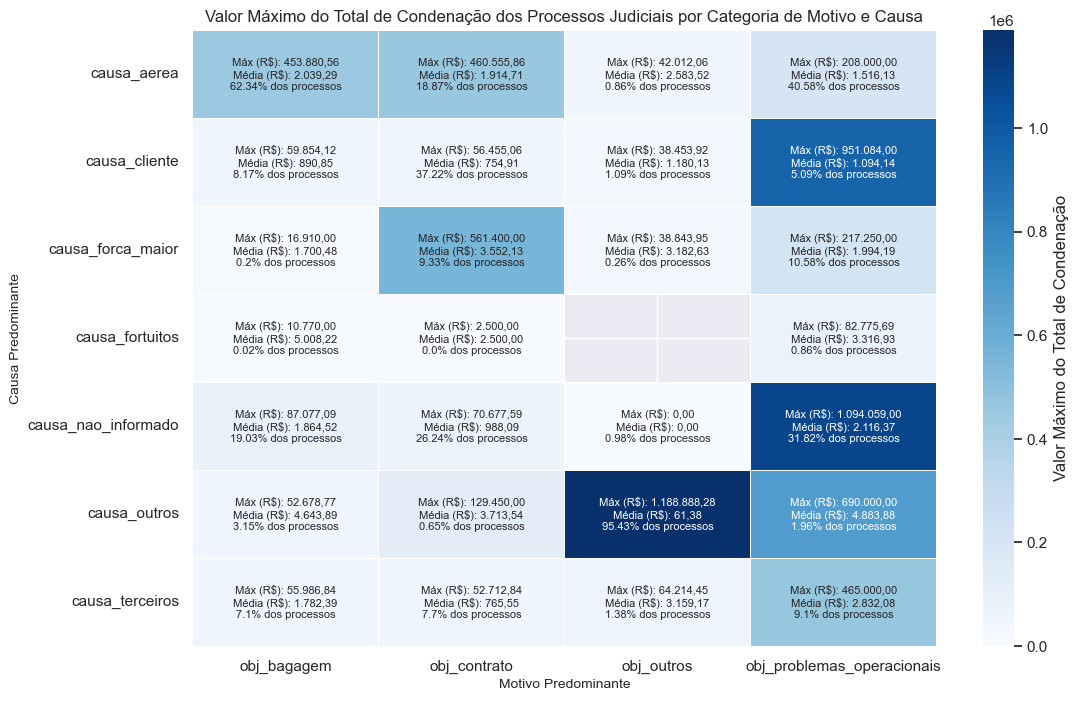

In [ ]:
# Agrupar por motivo (motivo_predominante) e causa (causa_predominante)
agg_data = dados_judicializacao_AED_filtro.groupby(['motivo_predominante', 'causa_predominante'])['valor_total_condenacao'].agg(['max', 'mean', 'count']).reset_index()

# Calcular o total de processos por ano
total_processos_motivo = dados_judicializacao_AED_filtro.groupby('motivo_predominante')['valor_total_condenacao'].count().reset_index(name='total_processos_motivo')

# Mesclar o total de processos por ano com o agg_data
agg_data = pd.merge(agg_data, total_processos_motivo, on='motivo_predominante')

# Calcular o percentual de processos
agg_data['percentual_processos'] = (agg_data['count'] / agg_data['total_processos_motivo']) * 100

# Criar uma nova coluna para armazenar os textos formatados que irão aparecer no heatmap
agg_data['texto'] = ('Máx (R$): ' + agg_data['max'].apply(lambda x: f'{x:,.2f}'.replace(',', 'X').replace('.', ',').replace('X', '.')) + '\n' +
                     'Média (R$): ' + agg_data['mean'].apply(lambda x: f'{x:,.2f}'.replace(',', 'X').replace('.', ',').replace('X', '.')) + '\n' +
                     agg_data['percentual_processos'].round(2).astype(str) + '% dos processos')

# Usar pivot_table para permitir agregação automática caso haja duplicação
heatmap_data = agg_data.pivot_table(index='causa_predominante', columns='motivo_predominante', values='max', aggfunc='max')
texto_data = agg_data.pivot_table(index='causa_predominante', columns='motivo_predominante', values='texto', aggfunc='first')  # 'first' para pegar o primeiro texto caso haja duplicatas

# Criar o heatmap com ajuste de tamanho do texto
plt.figure(figsize=(12, 8))  # Tamanho do gráfico
sns.heatmap(heatmap_data, cmap='Blues', annot=texto_data, fmt="",
            annot_kws={'size': 8},  # Ajustar o tamanho do texto
            cbar_kws={'label': 'Valor Máximo do Total de Condenação'}, linewidths=0.5)

# Adicionar título e rótulos aos eixos
plt.title('Valor Máximo do Total de Condenação dos Processos Judiciais por Categoria de Motivo e Causa', fontsize=12)
plt.xlabel('Motivo Predominante', fontsize=10)
plt.ylabel('Causa Predominante', fontsize=10)

# Salvar o gráfico em formato PNG
plt.savefig(f"condencao_motivo_causa.png", format="png", dpi=300)

# Exibir o gráfico
plt.show()

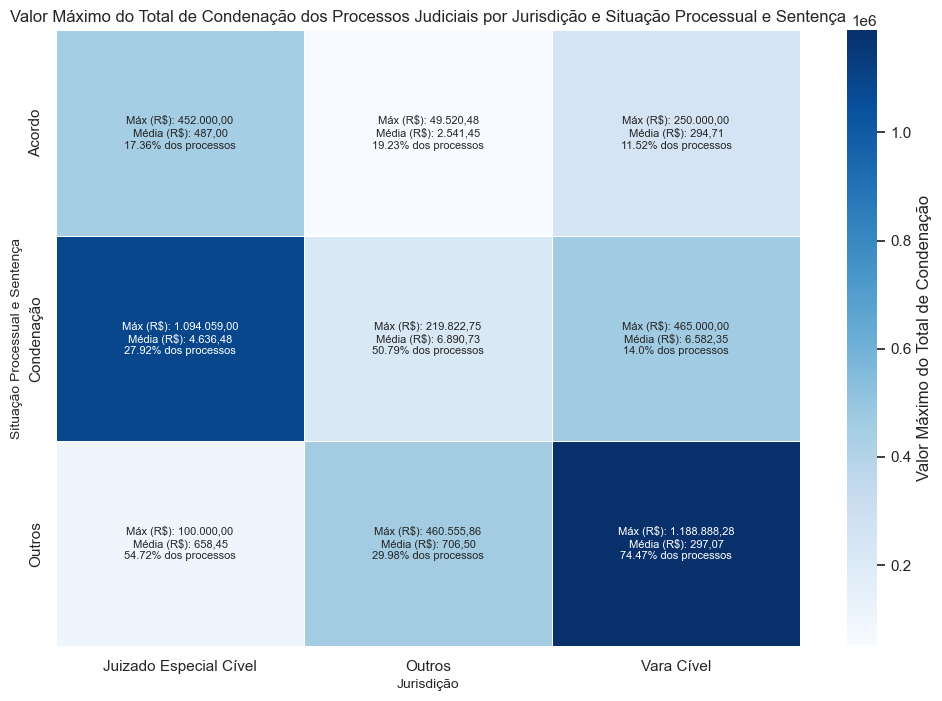

In [ ]:
# Agrupar por jurisdição (jurisdicao) e situação processual e sentença (situacao_processual_sentenca), e calcular o valor máximo, média e contagem de processos
agg_data = dados_judicializacao_AED_filtro.groupby(['jurisdicao', 'situacao_processual_sentenca'])['valor_total_condenacao'].agg(['max', 'mean', 'count']).reset_index()

# Calcular o total de processos por jurisdição
total_processos_jurisdicao = dados_judicializacao_AED_filtro.groupby('jurisdicao')['valor_total_condenacao'].count().reset_index(name='total_processos_jurisdicao')

# Mesclar o total de processos por jurisdição com o agg_data
agg_data = pd.merge(agg_data, total_processos_jurisdicao, on='jurisdicao')

# Calcular o percentual de processos
agg_data['percentual_processos'] = (agg_data['count'] / agg_data['total_processos_jurisdicao']) * 100

# Criar uma nova coluna para armazenar os textos formatados que irão aparecer no heatmap
agg_data['texto'] = ('Máx (R$): ' + agg_data['max'].apply(lambda x: f'{x:,.2f}'.replace(',', 'X').replace('.', ',').replace('X', '.')) + '\n' +
                     'Média (R$): ' + agg_data['mean'].apply(lambda x: f'{x:,.2f}'.replace(',', 'X').replace('.', ',').replace('X', '.')) + '\n' +
                     agg_data['percentual_processos'].round(2).astype(str) + '% dos processos')

# Pivotar os dados para que as jurisdições fiquem nas linhas e as situações processuais nas colunas
heatmap_data = agg_data.pivot(index='situacao_processual_sentenca', columns='jurisdicao', values='max')
texto_data = agg_data.pivot(index='situacao_processual_sentenca', columns='jurisdicao', values='texto')

# Criar o heatmap com ajuste de tamanho do texto
plt.figure(figsize=(12, 8))  # Tamanho do gráfico
sns.heatmap(heatmap_data, cmap='Blues', annot=texto_data, fmt="",
            annot_kws={'size': 8},  # Ajustar o tamanho do texto
            cbar_kws={'label': 'Valor Máximo do Total de Condenação'}, linewidths=0.5)

# Adicionar título e rótulos aos eixos
plt.title('Valor Máximo do Total de Condenação dos Processos Judiciais por Jurisdição e Situação Processual e Sentença', fontsize=12)
plt.xlabel('Jurisdição', fontsize=10)
plt.ylabel('Situação Processual e Sentença', fontsize=10)

# Salvar o gráfico em formato PNG
plt.savefig(f"condenacao_jurisdicao_situacao_processual_sentenca.png", format="png", dpi=300, bbox_inches="tight")

# Exibir o gráfico
plt.show()

###### Valor pago

In [ ]:
# Filtra o DataFrame para excluir os zeros na coluna 'valor_pago'
dados_sem_zero_valor_pago = dados_judicializacao_AED_filtro[dados_judicializacao_AED_filtro['valor_pago'] != 0]

# Calcula o valor mínimo da coluna 'valor_pago', desconsiderando os zeros
valor_minimo_valor_pago = dados_sem_zero_valor_pago['valor_pago'].min()

# Exibe o resultado
print("\nValor Mínimo da Coluna 'valor_pago' (Sem Zeros):")
print(valor_minimo_valor_pago)


Valor Mínimo da Coluna 'valor_pago' (Sem Zeros):
0.01


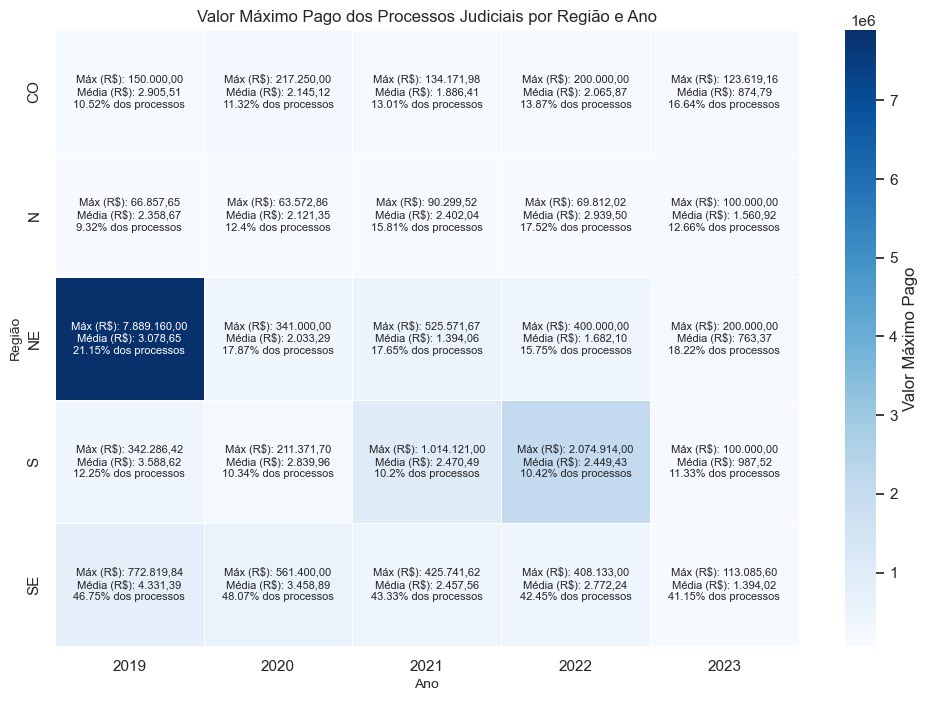

In [ ]:
# Agrupar por ano (num_proc_ano) e região (regiao), e calcular o valor máximo, média e contagem de processos
agg_data = dados_judicializacao_AED_filtro.groupby(['num_proc_ano', 'regiao'])['valor_pago'].agg(['max', 'mean', 'count']).reset_index()

# Calcular o total de processos por ano
total_processos_ano = dados_judicializacao_AED_filtro.groupby('num_proc_ano')['valor_pago'].count().reset_index(name='total_processos_ano')

# Mesclar o total de processos por ano com o agg_data
agg_data = pd.merge(agg_data, total_processos_ano, on='num_proc_ano')

# Calcular o percentual de processos
agg_data['percentual_processos'] = (agg_data['count'] / agg_data['total_processos_ano']) * 100

# Criar uma nova coluna para armazenar os textos formatados que irão aparecer no heatmap
agg_data['texto'] = ('Máx (R$): ' + agg_data['max'].apply(lambda x: f'{x:,.2f}'.replace(',', 'X').replace('.', ',').replace('X', '.')) + '\n' +
                     'Média (R$): ' + agg_data['mean'].apply(lambda x: f'{x:,.2f}'.replace(',', 'X').replace('.', ',').replace('X', '.')) + '\n' +
                     agg_data['percentual_processos'].round(2).astype(str) + '% dos processos')

# Pivotar os dados para que os anos fiquem nas colunas e as regiões nas linhas
heatmap_data = agg_data.pivot(index='regiao', columns='num_proc_ano', values='max')
texto_data = agg_data.pivot(index='regiao', columns='num_proc_ano', values='texto')

# Criar o heatmap com ajuste de tamanho do texto
plt.figure(figsize=(12, 8))  # Tamanho do gráfico
sns.heatmap(heatmap_data, cmap='Blues', annot=texto_data, fmt="",
            annot_kws={'size': 8},  # Ajustar o tamanho do texto
            cbar_kws={'label': 'Valor Máximo Pago'}, linewidths=0.5)

# Adicionar título e rótulos aos eixos
plt.title('Valor Máximo Pago dos Processos Judiciais por Região e Ano', fontsize=12)
plt.xlabel('Ano', fontsize=10)
plt.ylabel('Região', fontsize=10)

# Salvar o gráfico em formato PNG
plt.savefig(f"pago_ano_regiao.png", format="png", dpi=300)

# Exibir o gráfico
plt.show()

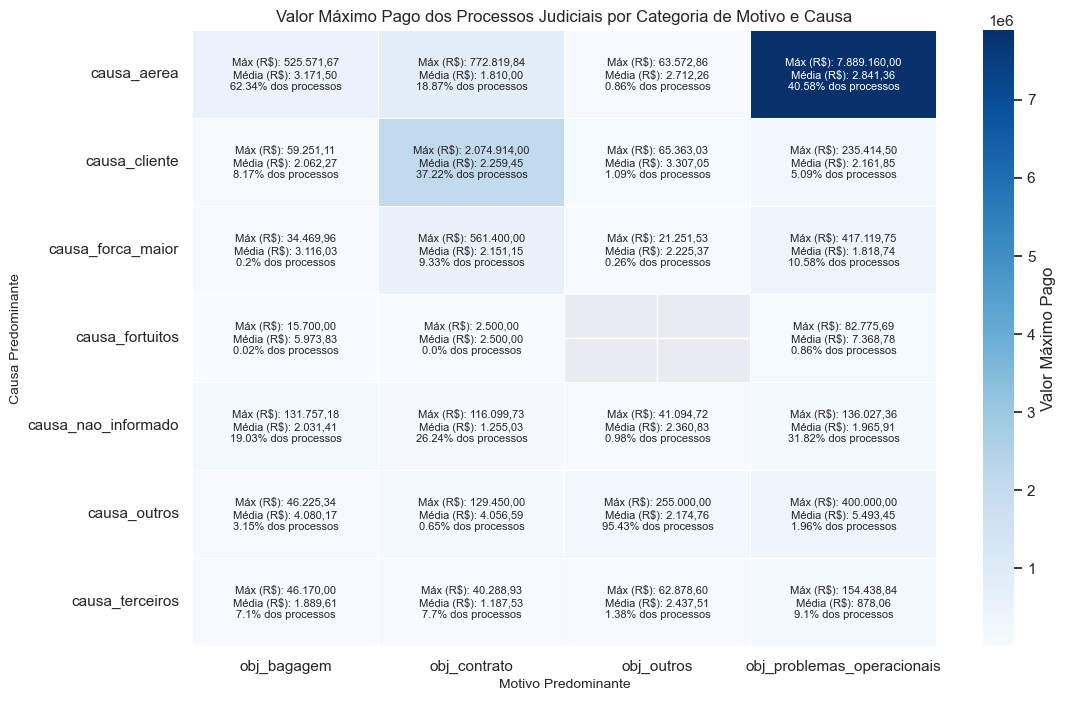

In [ ]:
# Agrupar por motivo (motivo_predominante) e causa (causa_predominante)
agg_data = dados_judicializacao_AED_filtro.groupby(['motivo_predominante', 'causa_predominante'])['valor_pago'].agg(['max', 'mean', 'count']).reset_index()

# Calcular o total de processos por ano
total_processos_motivo = dados_judicializacao_AED_filtro.groupby('motivo_predominante')['valor_pago'].count().reset_index(name='total_processos_motivo')

# Mesclar o total de processos por ano com o agg_data
agg_data = pd.merge(agg_data, total_processos_motivo, on='motivo_predominante')

# Calcular o percentual de processos
agg_data['percentual_processos'] = (agg_data['count'] / agg_data['total_processos_motivo']) * 100

# Criar uma nova coluna para armazenar os textos formatados que irão aparecer no heatmap
agg_data['texto'] = ('Máx (R$): ' + agg_data['max'].apply(lambda x: f'{x:,.2f}'.replace(',', 'X').replace('.', ',').replace('X', '.')) + '\n' +
                     'Média (R$): ' + agg_data['mean'].apply(lambda x: f'{x:,.2f}'.replace(',', 'X').replace('.', ',').replace('X', '.')) + '\n' +
                     agg_data['percentual_processos'].round(2).astype(str) + '% dos processos')

# Usar pivot_table para permitir agregação automática caso haja duplicação
heatmap_data = agg_data.pivot_table(index='causa_predominante', columns='motivo_predominante', values='max', aggfunc='max')
texto_data = agg_data.pivot_table(index='causa_predominante', columns='motivo_predominante', values='texto', aggfunc='first')  # 'first' para pegar o primeiro texto caso haja duplicatas

# Criar o heatmap com ajuste de tamanho do texto
plt.figure(figsize=(12, 8))  # Tamanho do gráfico
sns.heatmap(heatmap_data, cmap='Blues', annot=texto_data, fmt="",
            annot_kws={'size': 8},  # Ajustar o tamanho do texto
            cbar_kws={'label': 'Valor Máximo Pago'}, linewidths=0.5)

# Adicionar título e rótulos aos eixos
plt.title('Valor Máximo Pago dos Processos Judiciais por Categoria de Motivo e Causa', fontsize=12)
plt.xlabel('Motivo Predominante', fontsize=10)
plt.ylabel('Causa Predominante', fontsize=10)

# Salvar o gráfico em formato PNG
plt.savefig(f"pago_motivo_causa.png", format="png", dpi=300)

# Exibir o gráfico
plt.show()

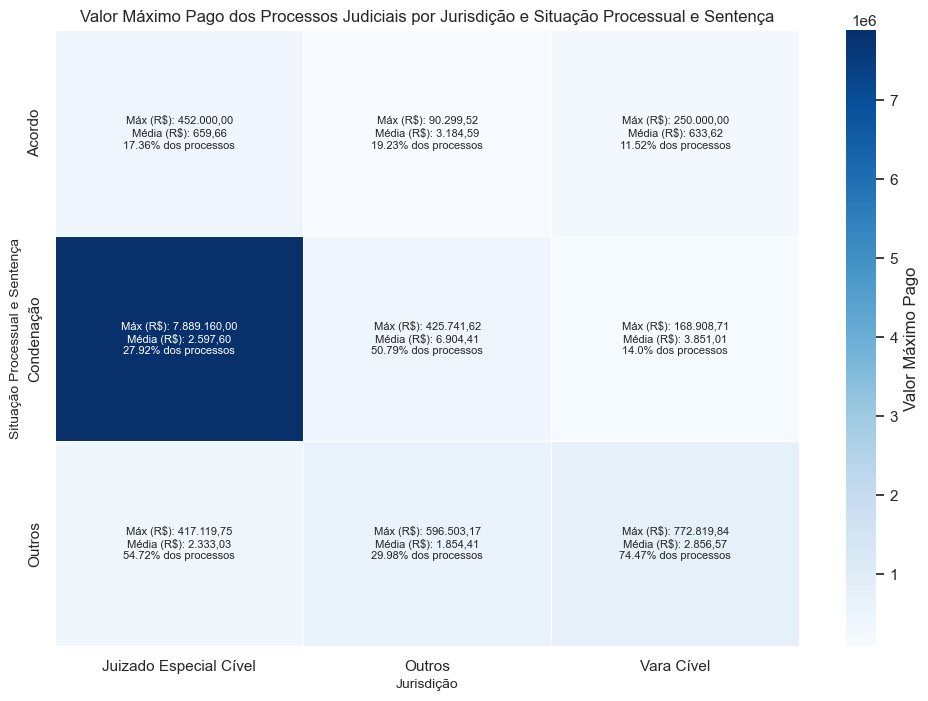

In [ ]:
# Agrupar por jurisdição (jurisdicao) e situação processual e sentença (situacao_processual_sentenca), e calcular o valor máximo, média e contagem de processos
agg_data = dados_judicializacao_AED_filtro.groupby(['jurisdicao', 'situacao_processual_sentenca'])['valor_pago'].agg(['max', 'mean', 'count']).reset_index()

# Calcular o total de processos por jurisdição
total_processos_jurisdicao = dados_judicializacao_AED_filtro.groupby('jurisdicao')['valor_pago'].count().reset_index(name='total_processos_jurisdicao')

# Mesclar o total de processos por jurisdição com o agg_data
agg_data = pd.merge(agg_data, total_processos_jurisdicao, on='jurisdicao')

# Calcular o percentual de processos
agg_data['percentual_processos'] = (agg_data['count'] / agg_data['total_processos_jurisdicao']) * 100

# Criar uma nova coluna para armazenar os textos formatados que irão aparecer no heatmap
agg_data['texto'] = ('Máx (R$): ' + agg_data['max'].apply(lambda x: f'{x:,.2f}'.replace(',', 'X').replace('.', ',').replace('X', '.')) + '\n' +
                     'Média (R$): ' + agg_data['mean'].apply(lambda x: f'{x:,.2f}'.replace(',', 'X').replace('.', ',').replace('X', '.')) + '\n' +
                     agg_data['percentual_processos'].round(2).astype(str) + '% dos processos')

# Pivotar os dados para que as jurisdições fiquem nas linhas e as situações processuais nas colunas
heatmap_data = agg_data.pivot(index='situacao_processual_sentenca', columns='jurisdicao', values='max')
texto_data = agg_data.pivot(index='situacao_processual_sentenca', columns='jurisdicao', values='texto')

# Criar o heatmap com ajuste de tamanho do texto
plt.figure(figsize=(12, 8))  # Tamanho do gráfico
sns.heatmap(heatmap_data, cmap='Blues', annot=texto_data, fmt="",
            annot_kws={'size': 8},  # Ajustar o tamanho do texto
            cbar_kws={'label': 'Valor Máximo Pago'}, linewidths=0.5)

# Adicionar título e rótulos aos eixos
plt.title('Valor Máximo Pago dos Processos Judiciais por Jurisdição e Situação Processual e Sentença', fontsize=12)
plt.xlabel('Jurisdição', fontsize=10)
plt.ylabel('Situação Processual e Sentença', fontsize=10)

# Salvar o gráfico em formato PNG
plt.savefig(f"pago_jurisdicao_situacao_processual_sentenca.png", format="png", dpi=300, bbox_inches="tight")

# Exibir o gráfico
plt.show()